In [3]:
import tensorflow as tf
from tensorflow import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1 #what portion of gpu to use
session = tf.Session(config=config)
keras.backend.set_session(session)

In [4]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Lambda, Add, concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt

import numpy as np

from keras.backend import resize_images
from skimage.transform import resize

cGAN implementation:

In [ ]:
# based on implementation in:
# https://github.com/eriklindernoren/Keras-GAN

# in this one the networks are fully connected
# a variant with CNNs is included further down

class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        #optimizer = Adam(0.0002, 0.5)
        optimizer = Adam(0.002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        fashion_mnist = keras.datasets.fashion_mnist
        (X_train, y_train), (_, _) = fashion_mnist.load_data()
        
        #X_train = X_train / 255.0 
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=1).reshape(60000,28,28,1)
        
        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        #X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)
        
        print(X_train.shape)
        print(y_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs=1000, batch_size=32, sample_interval=2000)

This was used to save models so we can reuse them later:

In [34]:
cgan.discriminator.save('fashionCGAN_20_discriminator.h5')
cgan.generator.save('fashionCGAN_20_generator.h5')
cgan.combined.save('fashionCGAN_20_adversarial.h5')

In [62]:
D = cgan.discriminator
G = cgan.generator
A = cgan.combined

In [4]:
from keras.models import load_model
#D = load_model('fashionCGAN_20_2_discriminator.h5')
G = load_model('fashionCGAN_20_2_generator.h5')
#A = load_model('fashionCGAN_20_2_adversarial.h5')

/opt/anaconda/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [134]:
A

Generating some synthetic samples:

In [8]:
num = 60000
noise = np.random.uniform(-1.0, 1.0, size=[num, 100])
labels = np.arange(0, 10).repeat(num/10).reshape(-1, 1)
images_fake = G.predict([noise, labels])

In [9]:
print(images_fake.shape)
print(labels.shape)

(60000, 28, 28, 1)
(60000, 1)


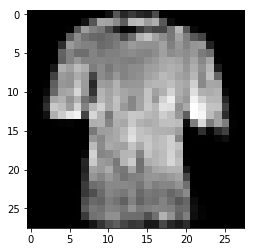

In [10]:
plt.imshow(images_fake[1901][:,:,0], cmap='gray')

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        
X_train = X_train/255.0
X_train = np.expand_dims(X_train, axis=1).reshape(60000,28,28,1)
        
y_train = y_train.reshape(-1, 1)
        
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000, 1)


In [4]:
X_test = X_test/255.0
X_test = np.expand_dims(X_test, axis=1).reshape(10000,28,28,1)
        
y_test = y_test.reshape(-1, 1)

print(X_test.shape)
print(y_test.shape)

(10000, 28, 28, 1)
(10000, 1)


In [13]:
#images_fake = 0.5 * images_fake + 0.5

In [14]:
X_train_new = np.concatenate((X_train, images_fake))
X_train_new.shape

(120000, 28, 28, 1)

In [15]:
y_train_new = np.concatenate((y_train, labels))
y_train_new.shape

(120000, 1)

I was doing some experimentation with training a classifier to check if training with reals and fakes together would improve accuracy (currently it looks about the same, but it's showing promise):

In [24]:
model=keras.models.Sequential() # 28x28x3
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation="relu")) # 26x26x32
keras.layers.BatchNormalization()
model.add(keras.layers.Conv2D(16, (3, 3), activation="relu")) # 24x24x16
keras.layers.BatchNormalization()
model.add(keras.layers.Conv2D(10, (3, 3), activation="relu")) # 22x22x10
keras.layers.BatchNormalization()
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2))) # 11x11x10
model.add(keras.layers.Flatten()) # 1210
model.add(keras.layers.Dense(256, activation="relu")) # 256
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(64, activation="relu")) # 64
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax)) # 10
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
realDataOnly = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 282us/step - loss: 0.5115 - acc: 0.8168 - val_loss: 0.3448 - val_acc: 0.8757
Epoch 2/10
60000/60000 [==============================] - 15s 255us/step - loss: 0.3279 - acc: 0.8821 - val_loss: 0.3219 - val_acc: 0.8810
Epoch 3/10
60000/60000 [==============================] - 15s 254us/step - loss: 0.2806 - acc: 0.8989 - val_loss: 0.2580 - val_acc: 0.9055
Epoch 4/10
60000/60000 [==============================] - 15s 256us/step - loss: 0.2483 - acc: 0.9103 - val_loss: 0.2607 - val_acc: 0.9095
Epoch 5/10
60000/60000 [==============================] - 15s 254us/step - loss: 0.2260 - acc: 0.9178 - val_loss: 0.2663 - val_acc: 0.9067
Epoch 6/10
60000/60000 [==============================] - 15s 255us/step - loss: 0.2039 - acc: 0.9257 - val_loss: 0.2422 - val_acc: 0.9154
Epoch 7/10
60000/60000 [==============================] - 15s 255us/step - loss: 0.1865 - acc: 0.9317 - val_loss: 0.

In [39]:
model=keras.models.Sequential() # 28x28x3
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation="relu")) # 26x26x32
keras.layers.BatchNormalization()
model.add(keras.layers.Conv2D(16, (3, 3), activation="relu")) # 24x24x16
keras.layers.BatchNormalization()
model.add(keras.layers.Conv2D(10, (3, 3), activation="relu")) # 22x22x10
keras.layers.BatchNormalization()
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2))) # 11x11x10
model.add(keras.layers.Flatten()) # 1210
model.add(keras.layers.Dense(256, activation="relu")) # 256
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(64, activation="relu")) # 64
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax)) # 10
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fakeDataOnly = model.fit(images_fake, labels, validation_data=(X_test, y_test), epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 289us/step - loss: 0.2675 - acc: 0.9085 - val_loss: 0.8559 - val_acc: 0.7997
Epoch 2/10
60000/60000 [==============================] - 15s 255us/step - loss: 0.0596 - acc: 0.9814 - val_loss: 0.9550 - val_acc: 0.8100
Epoch 3/10
60000/60000 [==============================] - 15s 255us/step - loss: 0.0363 - acc: 0.9887 - val_loss: 1.1483 - val_acc: 0.8010
Epoch 4/10
60000/60000 [==============================] - 15s 255us/step - loss: 0.0288 - acc: 0.9908 - val_loss: 1.0933 - val_acc: 0.7975
Epoch 5/10
60000/60000 [==============================] - 15s 254us/step - loss: 0.0224 - acc: 0.9930 - val_loss: 1.0783 - val_acc: 0.7980
Epoch 6/10
60000/60000 [==============================] - 16s 272us/step - loss: 0.0185 - acc: 0.9944 - val_loss: 1.1940 - val_acc: 0.8040
Epoch 7/10
60000/60000 [==============================] - 17s 287us/step - loss: 0.0163 - acc: 0.9951 - val_loss: 1.

In [18]:
model=keras.models.Sequential() # 28x28x3
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation="relu")) # 26x26x32
keras.layers.BatchNormalization()
model.add(keras.layers.Conv2D(16, (3, 3), activation="relu")) # 24x24x16
keras.layers.BatchNormalization()
model.add(keras.layers.Conv2D(10, (3, 3), activation="relu")) # 22x22x10
keras.layers.BatchNormalization()
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2))) # 11x11x10
model.add(keras.layers.Flatten()) # 1210
model.add(keras.layers.Dense(256, activation="relu")) # 256
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(64, activation="relu")) # 64
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax)) # 10
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
realDataPlusGenerated = model.fit(X_train_new, y_train_new, validation_data=(X_test, y_test), epochs=20)

Train on 120000 samples, validate on 10000 samples
Epoch 1/20
120000/120000 [==============================] - 31s 261us/step - loss: 0.3334 - acc: 0.8849 - val_loss: 0.3146 - val_acc: 0.8853
Epoch 2/20
120000/120000 [==============================] - 30s 250us/step - loss: 0.1882 - acc: 0.9354 - val_loss: 0.2802 - val_acc: 0.8975
Epoch 3/20
120000/120000 [==============================] - 30s 251us/step - loss: 0.1523 - acc: 0.9474 - val_loss: 0.2689 - val_acc: 0.9025
Epoch 4/20
120000/120000 [==============================] - 30s 248us/step - loss: 0.1326 - acc: 0.9538 - val_loss: 0.2898 - val_acc: 0.9007
Epoch 5/20
120000/120000 [==============================] - 30s 246us/step - loss: 0.1153 - acc: 0.9584 - val_loss: 0.2625 - val_acc: 0.9066
Epoch 6/20
120000/120000 [==============================] - 30s 247us/step - loss: 0.1030 - acc: 0.9627 - val_loss: 0.2582 - val_acc: 0.9119
Epoch 7/20
120000/120000 [==============================] - 30s 247us/step - loss: 0.0926 - acc: 0.9666

Plotting a confusion matrix:

In [51]:
import operator

y_prob = model.predict(X_test)

y_pred = np.zeros((10000))
i = 0
for prob in y_prob:
    index, value = max(enumerate(prob), key=operator.itemgetter(1))
    y_pred[i] = index
    i += 1


In [52]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[809   7  27  50   3   3  94   0   7   0]
 [  1 962   4  23   3   0   5   0   2   0]
 [ 25   2 776  11  97   1  85   0   3   0]
 [ 21  29  10 872  20   2  41   0   4   1]
 [ 13  14 242  64 481   0 177   0   9   0]
 [  0   0   0   0   0 947   0  22   2  29]
 [219   8 196  51  55   4 451   0  16   0]
 [  0   0   0   0   0  42   0 916   0  42]
 [ 11   7  16  13   7  16  20   7 901   2]
 [  0   1   0   0   0  12   1  45   0 941]]


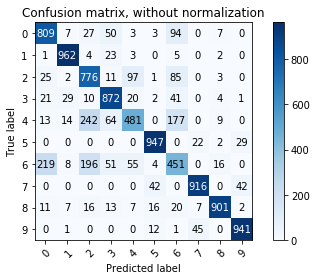

In [56]:
plot_confusion_matrix(y_test, y_pred, classes=np.arange(10), title='Confusion matrix, without normalization')

Next, i made plots of accuracy for reals/fakes/both, so we can see the results better:

In [19]:
def plot_history(hist, keys):
  plt.figure(figsize=(8,5))
    
  (name, history) = hist
  
  for key in keys:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=key + ' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=key+' Train')

  plt.xlabel('Epochs')
  plt.legend()

  plt.xlim([0,max(history.epoch)])

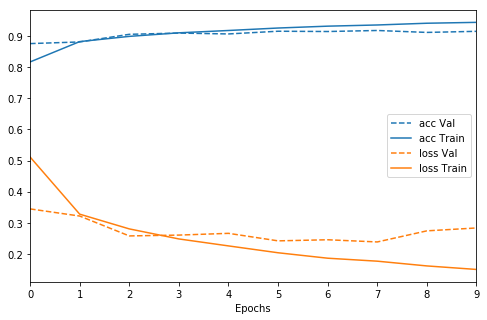

In [25]:
plot_history(('realDataOnly', realDataOnly), ['acc','loss'])

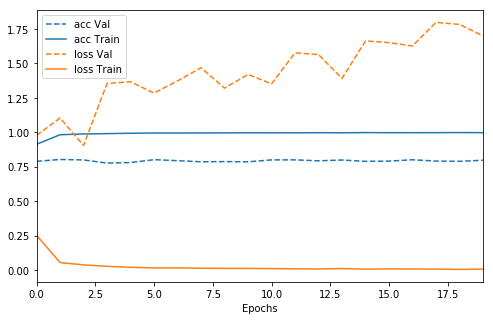

In [21]:
plot_history(('fakeDataOnly', fakeDataOnly), ['acc','loss'])

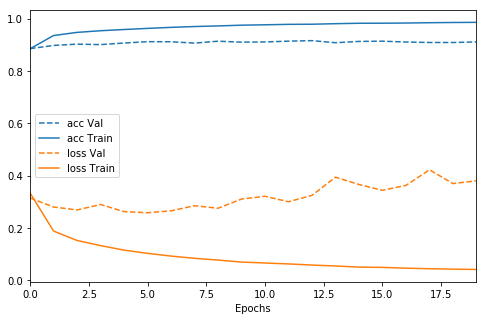

In [23]:
plot_history(('realDataPlusGenerated', realDataPlusGenerated), ['acc','loss'])

In [131]:
model=keras.models.Sequential() # 28x28x3
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), strides=(2,2), activation="relu")) # 13x13x32
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2))) # 6x6x32
model.add(keras.layers.Flatten()) # 1152
model.add(keras.layers.Dense(300, activation="relu")) # 300
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(40, activation="relu")) # 40
model.add(keras.layers.Dense(10, activation=tf.nn.softmax)) # 10
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
realDataOnly2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 279us/step - loss: 0.5347 - acc: 0.8031 - val_loss: 0.3793 - val_acc: 0.8607
Epoch 2/10
60000/60000 [==============================] - 11s 186us/step - loss: 0.3660 - acc: 0.8641 - val_loss: 0.3386 - val_acc: 0.8752
Epoch 3/10
60000/60000 [==============================] - 11s 189us/step - loss: 0.3282 - acc: 0.8783 - val_loss: 0.3191 - val_acc: 0.8816
Epoch 4/10
60000/60000 [==============================] - 11s 186us/step - loss: 0.3022 - acc: 0.8883 - val_loss: 0.3251 - val_acc: 0.8819
Epoch 5/10
60000/60000 [==============================] - 11s 186us/step - loss: 0.2840 - acc: 0.8946 - val_loss: 0.3083 - val_acc: 0.8861
Epoch 6/10
60000/60000 [==============================] - 11s 187us/step - loss: 0.2678 - acc: 0.8991 - val_loss: 0.2955 - val_acc: 0.8934
Epoch 7/10
60000/60000 [==============================] - 11s 186us/step - loss: 0.2538 - acc: 0.9045 - val_loss: 0.

In [137]:
model=keras.models.Sequential() # 28x28x3
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), strides=(2,2), activation="relu")) # 13x13x32
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2))) # 6x6x32
model.add(keras.layers.Flatten()) # 1152
model.add(keras.layers.Dense(300, activation="relu")) # 300
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(40, activation="relu")) # 40
model.add(keras.layers.Dense(10, activation=tf.nn.softmax)) # 10
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
realDataPlusGenerated2 = model.fit(X_train_new, y_train_new, validation_data=(X_test, y_test), epochs=10)

Train on 70000 samples, validate on 10000 samples
Epoch 1/10
70000/70000 [==============================] - 19s 275us/step - loss: 0.5495 - acc: 0.8023 - val_loss: 0.4149 - val_acc: 0.8480
Epoch 2/10
70000/70000 [==============================] - 13s 187us/step - loss: 0.3625 - acc: 0.8677 - val_loss: 0.3468 - val_acc: 0.8728
Epoch 3/10
70000/70000 [==============================] - 13s 186us/step - loss: 0.3143 - acc: 0.8842 - val_loss: 0.3227 - val_acc: 0.8838
Epoch 4/10
70000/70000 [==============================] - 13s 187us/step - loss: 0.2877 - acc: 0.8938 - val_loss: 0.3178 - val_acc: 0.8823
Epoch 5/10
70000/70000 [==============================] - 13s 188us/step - loss: 0.2681 - acc: 0.8995 - val_loss: 0.3130 - val_acc: 0.8871
Epoch 6/10
70000/70000 [==============================] - 13s 187us/step - loss: 0.2520 - acc: 0.9065 - val_loss: 0.3019 - val_acc: 0.8934
Epoch 7/10
70000/70000 [==============================] - 13s 187us/step - loss: 0.2378 - acc: 0.9111 - val_loss: 0.

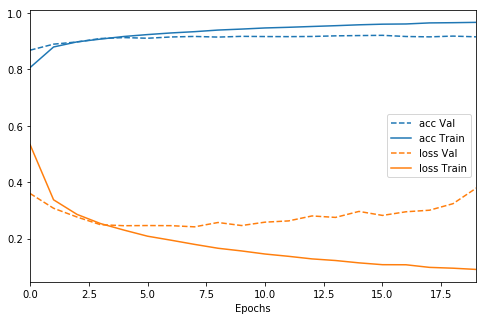

In [141]:
plot_history(('realDataOnly2', realDataOnly), ['acc','loss'])

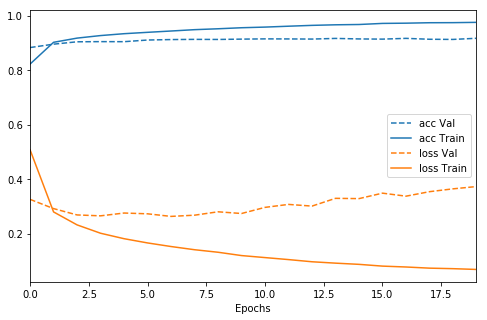

In [142]:
plot_history(('realDataPlusGenerated2', realDataPlusGenerated), ['acc','loss'])

Also, I wanted to do PCA on all images to see if the reals and fakes from the same class cluster together etc:

In [27]:
import scipy

img_points = X_train.reshape((60000,784))
img_points.shape

(60000, 784)

In [28]:
imagesByClass = {}
for i in range(60000):
    if y_train[i][0] in imagesByClass:
        imagesByClass[y_train[i][0]] = np.vstack((imagesByClass[y_train[i][0]], img_points[i]))
    else:
        imagesByClass[y_train[i][0]] = img_points[i]

In [53]:
d = np.zeros((10))
for i in range(10):
    d[i]= np.average(scipy.spatial.distance.cdist(imagesByClass[i], imagesByClass[i], 'euclidean'))
d

array([ 8.72214732,  6.88353736,  9.45460558,  8.23500918,  8.96112088,
        8.7124607 ,  9.52230823,  6.90989152, 10.91689322,  8.87074151])

In [50]:
np.save('real_dist.npy', d)

In [29]:
fake_points = images_fake.reshape((60000,784))
fake_points.shape

(60000, 784)

In [30]:
fakeImagesByClass = {}
for i in range(60000):
    if labels[i][0] in fakeImagesByClass:
        fakeImagesByClass[labels[i][0]] = np.vstack((fakeImagesByClass[labels[i][0]], fake_points[i]))
    else:
        fakeImagesByClass[labels[i][0]] = fake_points[i]

In [56]:
d_fake = np.zeros((10))
for i in range(10):
    d_fake[i]= np.average(scipy.spatial.distance.cdist(fakeImagesByClass[i], fakeImagesByClass[i], 'euclidean'))
d_fake

array([8.22533817, 7.69224743, 9.25872399, 8.7246527 , 8.99059488,
       8.74770976, 9.32473807, 6.3052051 , 9.5135942 , 8.01520424])

In [57]:
np.save('fake_dist_3.npy', d_fake)

In [31]:
imagesByClass[0][0:100].shape

(100, 784)

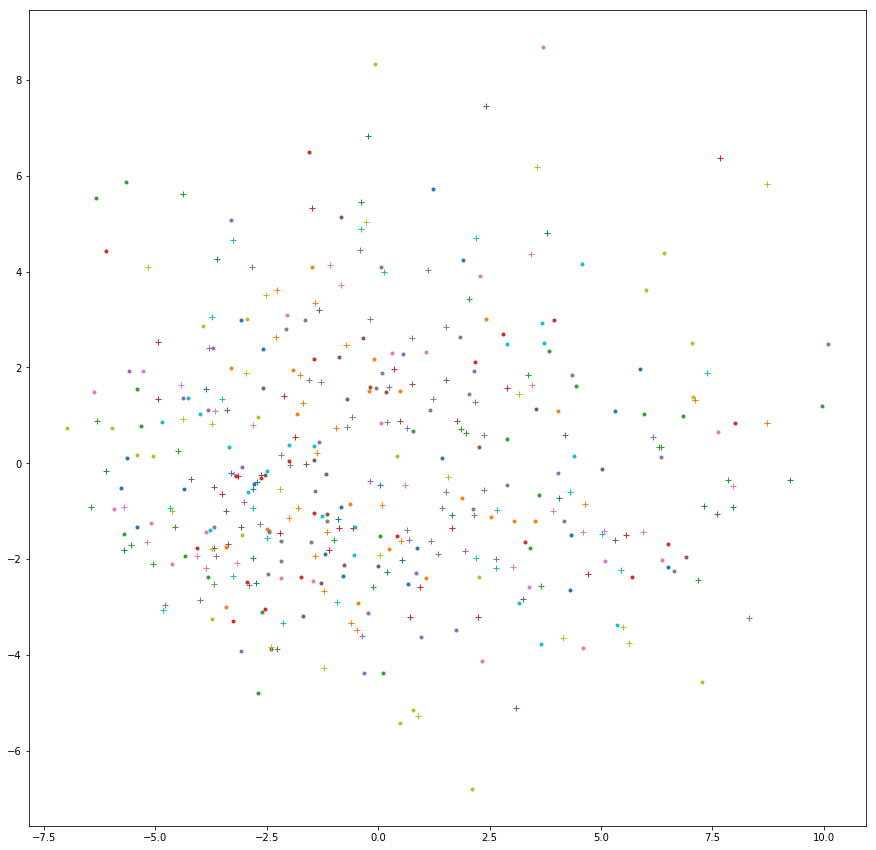

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure(figsize=(15, 15))

for i in range(10):
    
    real_pca = PCA(n_components = 2)
    real_transformed = real_pca.fit_transform(imagesByClass[i][40:60])
    fake_pca = PCA(n_components = 2)
    fake_transformed = fake_pca.fit_transform(fakeImagesByClass[i][40:60])
    
    c = np.random.rand(3,1)
    plt.plot(real_transformed[:,0], real_transformed[:,1], c = colors[i], marker = '.', linewidth=0)
    plt.plot(fake_transformed[:,0], fake_transformed[:,1], c = colors[i], marker = '+', linewidth=0)
    
plt.show()

You can't see that well what's happening on the above plot, so I made one for each class separately:

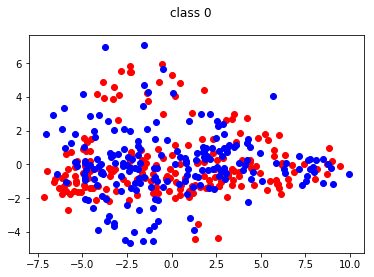

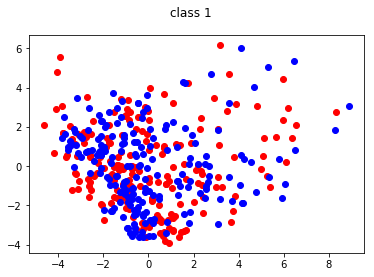

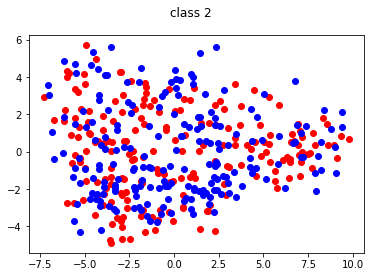

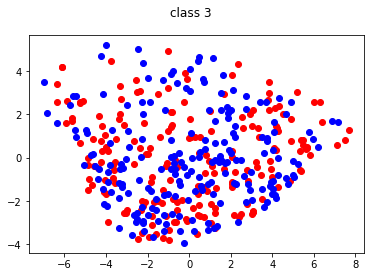

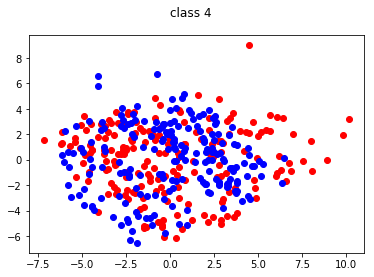

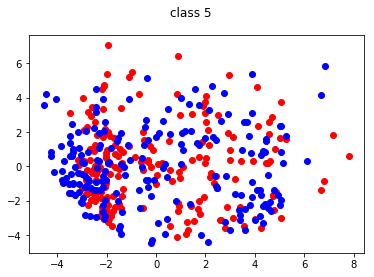

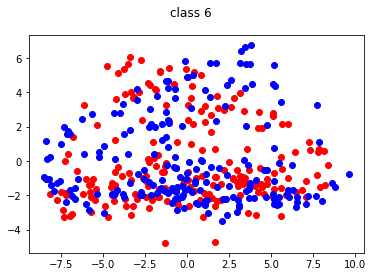

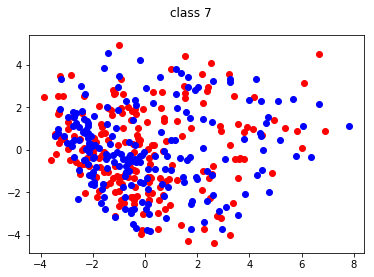

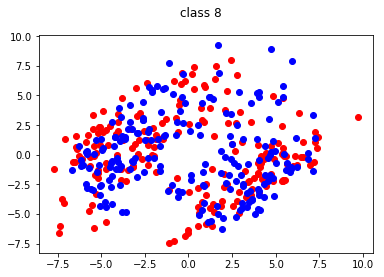

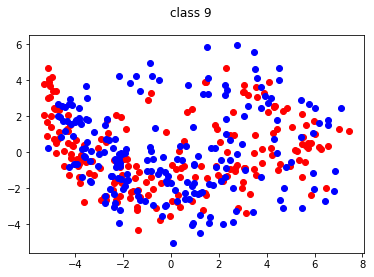

In [33]:
for i in range(10):
    
    real_pca = PCA(n_components = 2)
    real_transformed = real_pca.fit_transform(imagesByClass[i][400:600])
    fake_pca = PCA(n_components = 2)
    fake_transformed = fake_pca.fit_transform(fakeImagesByClass[i][400:600])
    
    c = np.random.rand(3,1)
    plt.plot(real_transformed[:,0], real_transformed[:,1], 'ro')
    plt.plot(fake_transformed[:,0], fake_transformed[:,1], 'bo')
    plt.suptitle('class ' + str(i))
    plt.show()

Here, I changed the architecture of the discrminator and generator to CNNs for improved results:

In [ ]:
class CGAN2():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        #optimizer = Adam(0.0002, 0.5)
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

    def build_generator(self):
        
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7

        model = Sequential()
        
        # In: 100
        # Out: dim x dim x depth
        model.add(Dense(dim*dim*depth, input_dim=100))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        model.add(Reshape((dim, dim, depth)))
        model.add(Dropout(dropout))
        
        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        model.add(Conv2DTranspose(1, 5, padding='same'))
        model.add(Activation('sigmoid'))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):
        
        depth = 64
        dropout = 0.4
        
        model = Sequential()
        model.add(Reshape(self.img_shape, input_shape=(784,)))
        
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        model.add(Conv2D(depth*1, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        # Out: 1-dim probability
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)
    
    def train2(self, epochs, X_train, y_train, batch_size=128, sample_interval=50):
        
        for epoch in range(epochs):
            
            idx = np.random.randint(0, X_train.shape[0], size=batch_size)
            images_train = X_train[idx]
            labels = y_train[idx]
            
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict([noise, labels])
            
            x = np.concatenate((images_train, images_fake))
            l = np.concatenate([labels, labels])
            
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            d_loss = self.discriminator.train_on_batch([x, l], y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
            
            a_loss = self.combined.train_on_batch([noise, sampled_labels], y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (epoch, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def train(self, epochs, X_train, y_train, batch_size=128, sample_interval=50):

        #fashion_mnist = keras.datasets.fashion_mnist
        #(X_train, y_train), (_, _) = fashion_mnist.load_data()
        
        #X_train = X_train / 255.0 
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        #X_train = np.expand_dims(X_train, axis=1).reshape(60000,28,28,1)
        
        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        #X_train = np.expand_dims(X_train, axis=3)
        #y_train = y_train.reshape(-1, 1)
        
        print(X_train.shape)
        print(y_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    cgan = CGAN2()
    cgan.train2(epochs=500, X_train = X_train, y_train = y_train, batch_size=64, sample_interval=50)

In [132]:
cgan.discriminator.save('fashionCGAN_improved_discriminator.h5')
cgan.generator.save('fashionCGAN_improved_generator.h5')
cgan.combined.save('fashionCGAN_improved_adversarial.h5')

Results with the fake images: (they look very good!!)

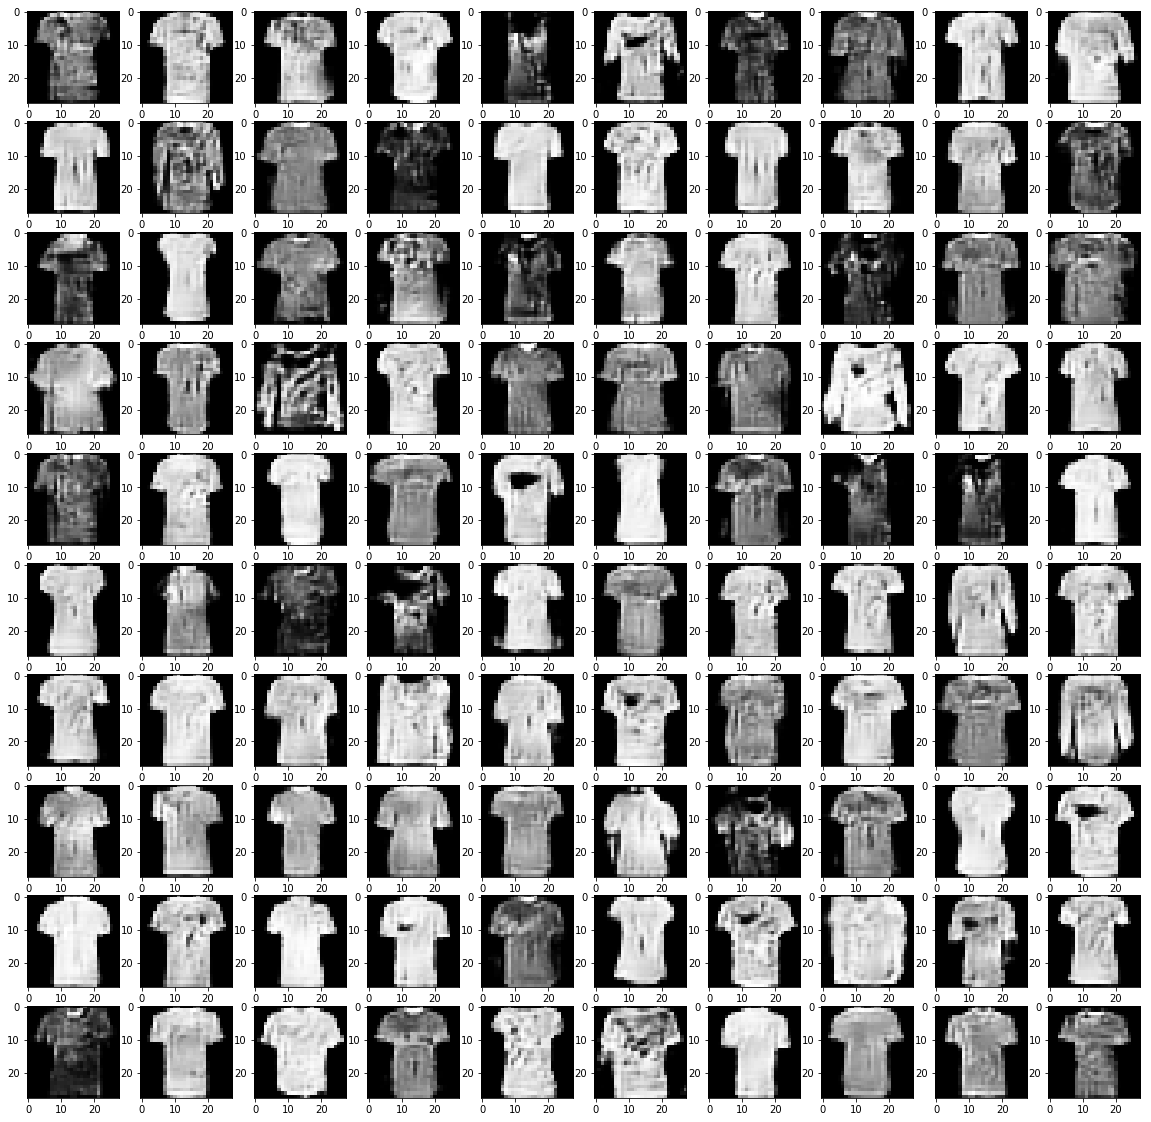

In [63]:
fig, axs = plt.subplots(10, 10,figsize=(20, 20))
cnt = 1400
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(images_fake[cnt,:,:,0], cmap='gray')
        cnt += 1
plt.show()
plt.close()

These are the real for comparison:

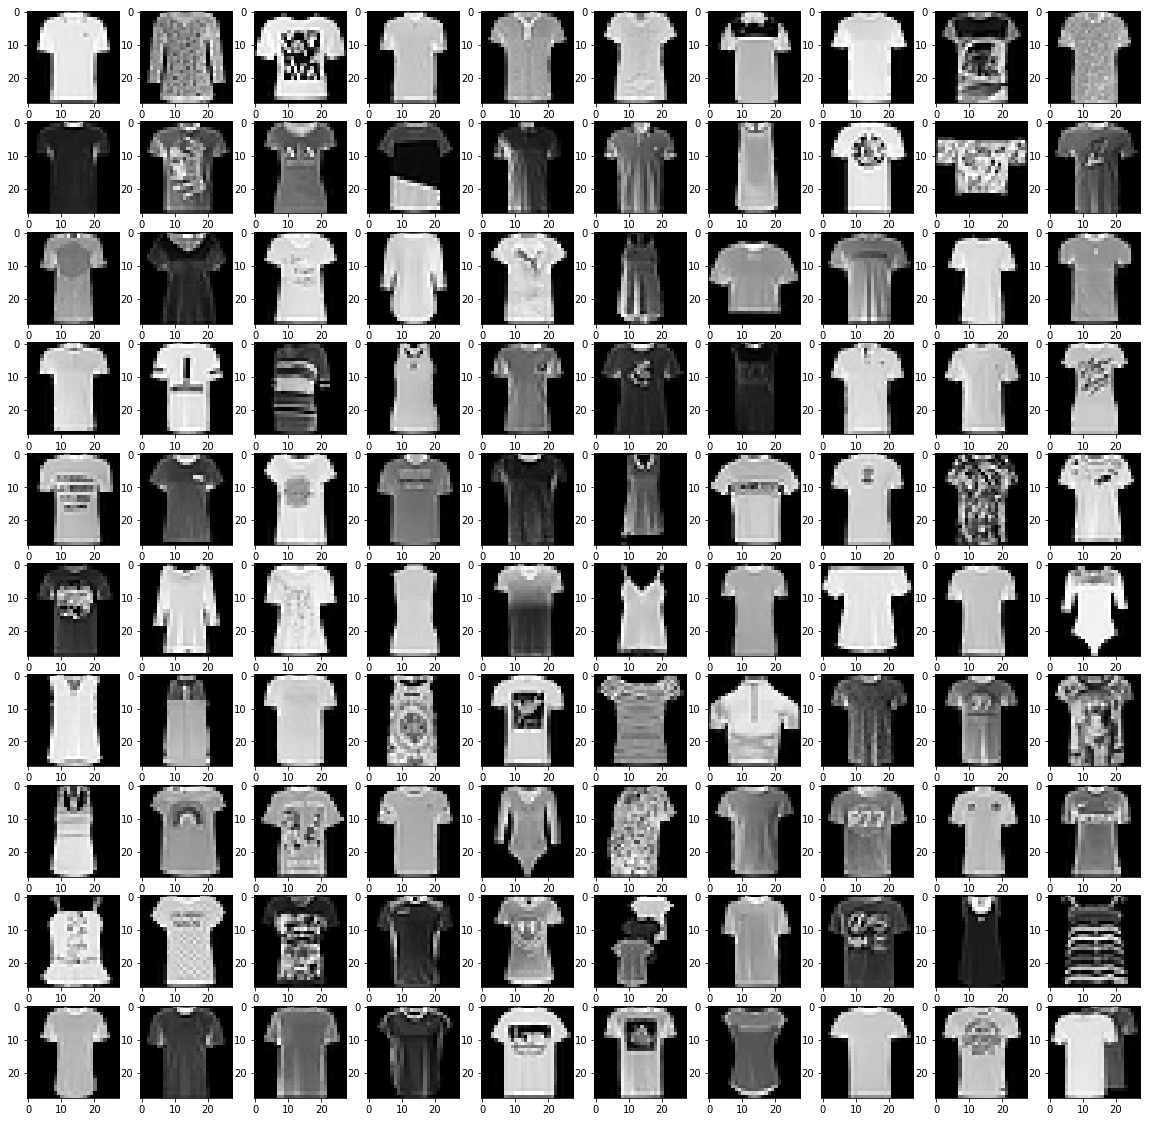

In [62]:
fig, axs = plt.subplots(10, 10,figsize=(20, 20))
cnt = 700
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(imagesByClass[0][cnt].reshape(28,28), cmap='gray')
        cnt += 1
plt.show()
plt.close()

In [196]:
imagesByClass[0].shape

(6000, 784)

Next, I was experimenting a bit with data augmentation to have even more training data and check results then. Not really the focus for us right now, you can skip it:

In [4]:
import imgaug as ia
from imgaug import augmenters as iaa

In [77]:
images = X_train*255
images = images.astype('uint8')

In [79]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.75), # horizontally flip 50% of all images
        #iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            #rotate=(-45, 45), # rotate by -45 to +45 degrees
            #shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
    ],
    random_order=True
)

images_aug = seq.augment_images(images)

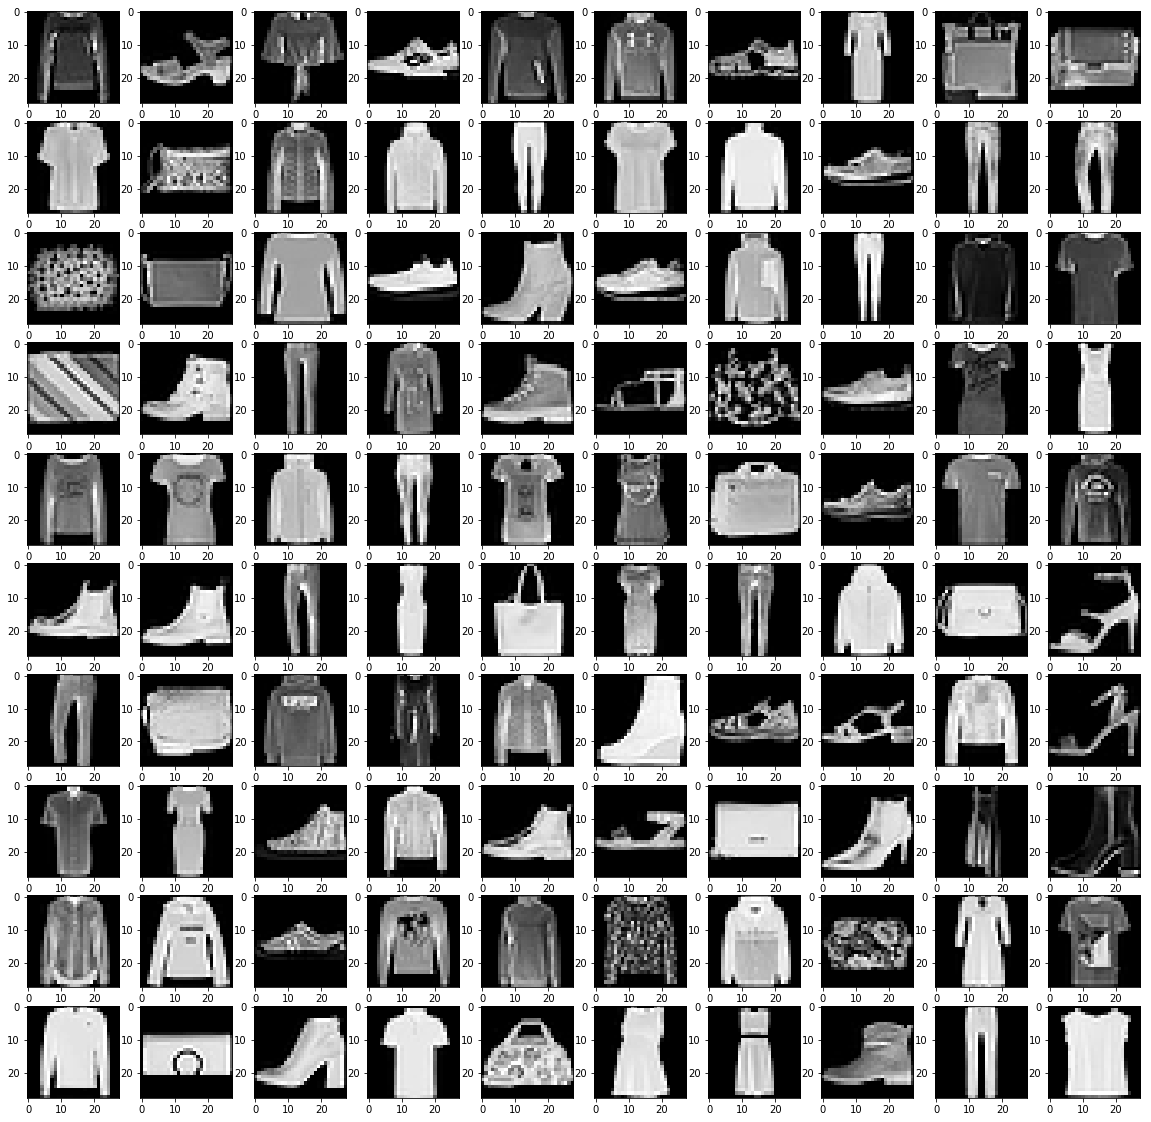

In [82]:
fig, axs = plt.subplots(10, 10,figsize=(20, 20))
cnt = 400
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(images[cnt].reshape(28,28), cmap='gray')
        cnt += 1
plt.show()
plt.close()

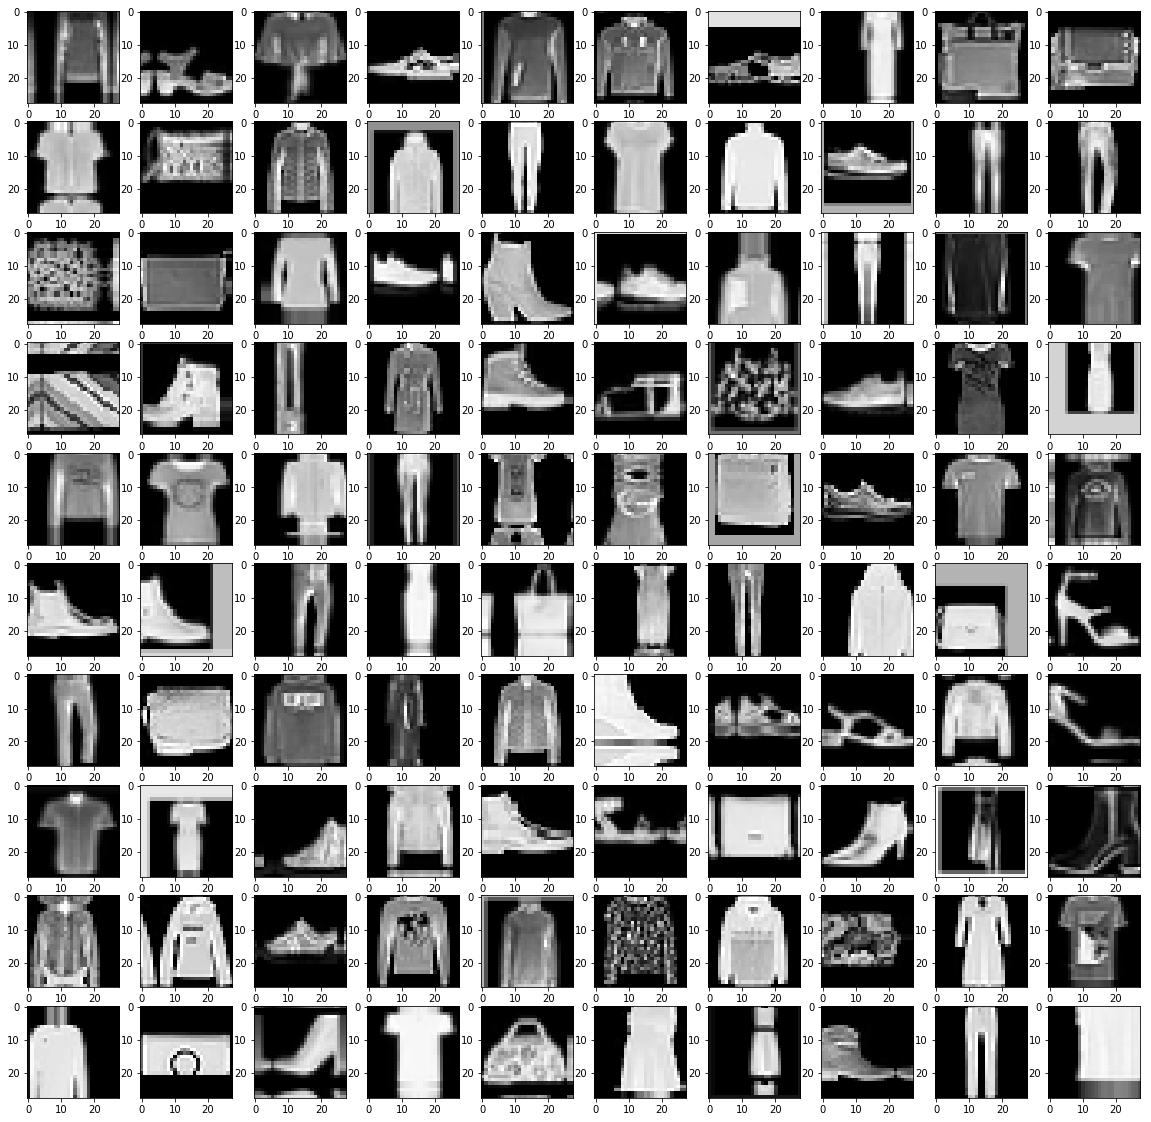

In [83]:
fig, axs = plt.subplots(10, 10,figsize=(20, 20))
cnt = 400
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(images_aug[cnt].reshape(28,28), cmap='gray')
        cnt += 1
plt.show()
plt.close()

In [84]:
X_train = np.concatenate((images, images_aug))
X_train = X_train/255
X_train.shape

(120000, 28, 28, 1)

In [85]:
y_train = np.concatenate((y_train, y_train))
y_train.shape

(120000, 1)

In [1]:
from random import shuffle
import math

class CGAN2():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        #optimizer = Adam(0.0002, 0.5)
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

    def build_generator(self):
        
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7

        model = Sequential()
        
        # In: 100
        # Out: dim x dim x depth
        model.add(Dense(dim*dim*depth, input_dim=100))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        model.add(Reshape((dim, dim, depth)))
        model.add(Dropout(dropout))
        
        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        model.add(Conv2DTranspose(1, 5, padding='same'))
        model.add(Activation('sigmoid'))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):
        
        depth = 64
        dropout = 0.4
        
        model = Sequential()
        model.add(Reshape(self.img_shape, input_shape=(784,)))
        
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        model.add(Conv2D(depth*1, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        # Out: 1-dim probability
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)
    
    def train2(self, epochs, X_train, y_train, batch_size=128, sample_interval=50):
        
        print(X_train.shape)
        print(y_train.shape)

        for epoch in range(epochs):
            
            print(epoch)
            
            idx = np.random.permutation(X_train.shape[0])
            X_train = X_train[idx]
            y_train = y_train[idx]
            
            for i in range(math.ceil(X_train.shape[0]/batch_size)):
            
                images_train = X_train[i*batch_size:min((i+1)*batch_size,X_train.shape[0])]
                labels = y_train[i*batch_size:min((i+1)*batch_size,X_train.shape[0])]
                
                cur_batch_size = images_train.shape[0]
            
                noise = np.random.uniform(-1.0, 1.0, size=[cur_batch_size, 100])
                images_fake = self.generator.predict([noise, labels])
            
                x = np.concatenate((images_train, images_fake))
                l = np.concatenate([labels, labels])
            
                y = np.ones([2*cur_batch_size, 1])
                y[cur_batch_size:, :] = 0
            
                d_loss = self.discriminator.train_on_batch([x, l], y)

                y = np.ones([batch_size, 1])
                noise = np.random.uniform(-1.0, 1.0, size=[cur_batch_size, 100])
                sampled_labels = np.random.randint(0, 10, cur_batch_size).reshape(-1, 1)
            
                a_loss = self.combined.train_on_batch([noise, sampled_labels], y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (epoch, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def train(self, epochs, X_train, y_train, batch_size=128, sample_interval=50):

        #fashion_mnist = keras.datasets.fashion_mnist
        #(X_train, y_train), (_, _) = fashion_mnist.load_data()
        
        #X_train = X_train / 255.0 
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        #X_train = np.expand_dims(X_train, axis=1).reshape(60000,28,28,1)
        
        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        #X_train = np.expand_dims(X_train, axis=3)
        #y_train = y_train.reshape(-1, 1)
        
        print(X_train.shape)
        print(y_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    cgan = CGAN2()
    cgan.train2(epochs=200, X_train = X_train, y_train = y_train, batch_size=200, sample_interval=1)
    cgan.discriminator.save('fashionCGAN_20_2_discriminator.h5')
    cgan.generator.save('fashionCGAN_20_2_generator.h5')
    cgan.combined.save('fashionCGAN_20_2_adversarial.h5')

NameError: name 'Adam' is not defined

Here, I was experimenting with the architecture for the network, because for the instestine dataset we will need a better one:

In [10]:
from random import shuffle
import math

class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        #optimizer = Adam(0.0002, 0.5)
        optimizer = Adam(1e-4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.img_shape))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

    def build_generator2(self):

        noise = Input(shape=(self.img_shape))
        label = Input(shape=(1,), dtype='int32')
        
        noise_flat = Flatten()(noise)
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))

        model_input = multiply([noise_flat, label_embedding])
        
        #x = Dense(np.prod(self.img_shape))(model_input) 
        x = Reshape(self.img_shape)(model_input) # 28 x 28 x 1
        
        c1 = Conv2D(filters=3, kernel_size=(3,3), dilation_rate=(1,1), activation='relu', padding='same')(x) 
        c1 = BatchNormalization()(c1)
        #c1 = Dropout(0.2)(c1)
        c2 = Conv2D(filters=3, kernel_size=(3,3), dilation_rate=(2,2), activation='relu', padding='same')(c1)
        c2 = BatchNormalization()(c2)
        #c2 = Dropout(0.2)(c2)
        c3 = Conv2D(filters=3, kernel_size=(3,3), dilation_rate=(4,4), activation='relu', padding='same')(c2)
        c3 = BatchNormalization()(c3)
        #c3 = Dropout(0.2)(c3)
        c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(c3) # 28 x 28 x 32
        c4 = BatchNormalization()(c4)
        c4 = Dropout(0.4)(c4)
        
        c5 = Conv2D(filters=32, kernel_size=(2,2), strides=(2,2), activation='relu')(c4) # 14 x 14 x 32
        c5 = BatchNormalization()(c5)
        #c5 = Dropout(0.2)(c5)
        c6 = Conv2D(filters=32, kernel_size=(3,3), dilation_rate=(1,1), activation='relu', padding='same')(c5) 
        c6 = BatchNormalization()(c6)
        #c6 = Dropout(0.2)(c6)
        c7 = Conv2D(filters=32, kernel_size=(3,3), dilation_rate=(2,2), activation='relu', padding='same')(c6)
        c7 = BatchNormalization()(c7)
        #c7 = Dropout(0.2)(c7)
        c8 = Conv2D(filters=32, kernel_size=(3,3), dilation_rate=(4,4), activation='relu', padding='same')(c7)
        c8 = BatchNormalization()(c8)
        #c8 = Dropout(0.2)(c8)
        c9 = Conv2D(filters=64, kernel_size=(1,1), activation='relu', padding='same')(c8) # 14 x 14 x 64
        c9 = BatchNormalization()(c9)
        c9 = Dropout(0.4)(c9)
        
        c10 = Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), activation='relu')(c9) # 14 x 14 x 64
        c10 = BatchNormalization()(c10)
        c10 = Dropout(0.2)(c10)
        c11 = Conv2D(filters=64, kernel_size=(3,3), dilation_rate=(1,1), activation='relu', padding='same')(c10) 
        c11 = BatchNormalization()(c11)
        #c11 = Dropout(0.2)(c11)
        c12 = Conv2D(filters=64, kernel_size=(3,3), dilation_rate=(2,2), activation='relu', padding='same')(c11)
        c12 = BatchNormalization()(c12)
        #c12 = Dropout(0.2)(c12)
        c13 = Conv2D(filters=64, kernel_size=(3,3), dilation_rate=(4,4), activation='relu', padding='same')(c12)
        c13 = BatchNormalization()(c13)
        #c13 = Dropout(0.2)(c13)
        c14 = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='same')(c13) # 7 x 7 x 128
        c14 = BatchNormalization()(c14)
        c14 = Dropout(0.4)(c14)
        
        #c15 = Conv2D(filters=128, kernel_size=(2,2), strides=(2,2), activation='relu')(c14) # 8 x 8 x 128
        #c15 = BatchNormalization()(c15)
        #c15 = Dropout(0.2)(c15)
        #c16 = Conv2D(filters=128, kernel_size=(3,3), dilation_rate=(1,1), activation='relu', padding='same')(c15) 
        #c16 = BatchNormalization()(c16)
        #c16 = Dropout(0.2)(c16)
        #c17 = Conv2D(filters=128, kernel_size=(3,3), dilation_rate=(2,2), activation='relu', padding='same')(c16)
        #c17 = BatchNormalization()(c17)
        #c17 = Dropout(0.2)(c17)
        #c18 = Conv2D(filters=128, kernel_size=(3,3), dilation_rate=(4,4), activation='relu', padding='same')(c17)
        #c18 = BatchNormalization()(c18)
        #c18 = Dropout(0.2)(c18)
        #c19 = Conv2D(filters=256, kernel_size=(1,1), activation='relu', padding='same')(c18) # 8 x 8 x 256
        #c19 = BatchNormalization()(c19)
        #c19 = Dropout(0.4)(c19)
        
        #x = Lambda(lambda x : resize_images(x, 2, 2, "channels_last"))(c19)
        #c20 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x) # 16 x 16 x 128
        #c20 = BatchNormalization()(c20)
        #c20 = Dropout(0.2)(c20)
        
        #s1 = Add()([c14, c20]) # 16 x 16 x 128
        #x = Lambda(lambda x : resize_images(x, 2, 2, "channels_last"))(s1)
        #c21 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x) # 32 x 32 x 64
        #c21 = BatchNormalization()(c21)
        #c21 = Dropout(0.2)(c21)

        #s2 = Add()([c9, c21]) # 32 x 32 x 64
        #x = Lambda(lambda x : resize_images(x, 2, 2, "channels_last"))(s2)
        #c22 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x) # 64 x 64 x 32
        #c22 = BatchNormalization()(c22)
        #c22 = Dropout(0.2)(c22)

        x = Lambda(lambda x : resize_images(x, 2, 2, "channels_last"))(c14) # 14 x 14 x 128
        c15 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x) # 14 x 14 x 64
        c15 = BatchNormalization()(c15)
        
        s2 = Add()([c9, c15]) # 14 x 14 x 64
        x = Lambda(lambda x : resize_images(x, 2, 2, "channels_last"))(s2) # 28 x 28 x 64
        c16 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x) # 28 x 28 x 32
        c16 = BatchNormalization()(c16)        
        
        s3 = Add()([c4, c16]) # 28 x 28 x 32
        c17 = Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(s3) # 28 x 28 x 1
        #c23 = BatchNormalization()(c23)

        model = Model(inputs=[noise, label], outputs=[c17])
        
        model.summary()
        
        return model
    
    def build_generator(self):
        
        inputs = Input(input_size)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    def build_discriminator(self):
        
        depth = 64
        dropout = 0.4
        
        model = Sequential()
        model.add(Reshape(self.img_shape, input_shape=(784,)))
        
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        model.add(Conv2D(depth*1, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        # Out: 1-dim probability
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)
    
    def train(self, epochs, X_train, y_train, batch_size=128, sample_interval=50):
        
        for epoch in range(epochs):
            
            idx = np.random.permutation(X_train.shape[0])
            X_train = X_train[idx]
            y_train = y_train[idx]
            
            for i in range(math.ceil(X_train.shape[0]/batch_size)):
            
                images_train = X_train[i*batch_size:min((i+1)*batch_size,X_train.shape[0])]
                labels = y_train[i*batch_size:min((i+1)*batch_size,X_train.shape[0])]
                
                cur_batch_size = images_train.shape[0]
            
                noise = np.random.uniform(-1.0, 1.0, size=[cur_batch_size, 28, 28, 1])
                
                images_fake = self.generator.predict([noise, labels])
            
                x = np.concatenate((images_train, images_fake))
                l = np.concatenate([labels, labels])
            
                y = np.ones([2*cur_batch_size, 1])
                y[cur_batch_size:, :] = 0
            
                d_loss = self.discriminator.train_on_batch([x, l], y)

                y = np.ones([batch_size, 1])
                noise = np.random.uniform(-1.0, 1.0, size=[cur_batch_size, 28, 28, 1])
                sampled_labels = np.random.randint(0, 10, cur_batch_size).reshape(-1, 1)
            
                a_loss = self.combined.train_on_batch([noise, sampled_labels], y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (epoch, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            
            if epoch % sample_interval == 0:
                self.sample_images(epoch, X_train)

    def sample_images(self, epoch, X_train):
        
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 28, 28, 1))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs=20, X_train = X_train, y_train = y_train, batch_size=200, sample_interval=1)
    cgan.discriminator.save('CGAN_UNET_fashion_discriminator.h5')
    cgan.generator.save('CGAN_UNET_fashion_generator.h5')
    cgan.combined.save('CGAN_UNET_fashion_adversarial.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 7, 7, 128)         0         
__________

/opt/anaconda/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.691308, acc: 0.497500]  [A loss: 0.683602, acc: 0.585000]
1: [D loss: 0.681872, acc: 0.527500]  [A loss: 0.730319, acc: 0.360000]
2: [D loss: 0.680453, acc: 0.590000]  [A loss: 0.812150, acc: 0.310000]
3: [D loss: 0.683928, acc: 0.555000]  [A loss: 0.730800, acc: 0.440000]
4: [D loss: 0.673052, acc: 0.575000]  [A loss: 0.759375, acc: 0.340000]
5: [D loss: 0.676764, acc: 0.547500]  [A loss: 0.752254, acc: 0.245000]
6: [D loss: 0.669084, acc: 0.535000]  [A loss: 0.780513, acc: 0.195000]
7: [D loss: 0.678811, acc: 0.587500]  [A loss: 0.783799, acc: 0.245000]
8: [D loss: 0.663281, acc: 0.612500]  [A loss: 0.806983, acc: 0.310000]
9: [D loss: 0.674009, acc: 0.570000]  [A loss: 0.839492, acc: 0.285000]
10: [D loss: 0.596047, acc: 0.682500]  [A loss: 1.085938, acc: 0.205000]
11: [D loss: 0.616620, acc: 0.645000]  [A loss: 0.888483, acc: 0.365000]
12: [D loss: 0.564434, acc: 0.687500]  [A loss: 0.921045, acc: 0.035000]
13: [D loss: 0.648695, acc: 0.567500]  [A loss: 0.886836, acc

In [ ]:
np.repeat(np.arrange(7),10))

Next, I tried to improve the CGAN by changing the loss fucntion to Wasserstein with gradient penalty. This wasn't straightforward. The rest of the file just holds a lot of experimentation with it. The final version that works for the intestine dataset, you can find in another file as explained in the report.

In [3]:
from keras.layers.merge import _Merge
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class Subtract(_Merge):
    def _merge_function(self, inputs):
        output = inputs[0]
        for i in range(1, len(inputs)):
            output = output-inputs[i]
        return output

class GradNorm(Layer):
    def __init__(self, **kwargs):
        super(GradNorm, self).__init__(**kwargs)

    def build(self, input_shapes):
        # Create a trainable weight variable for this layer.
        super(GradNorm, self).build(input_shapes)  # Be sure to call this somewhere!

    def call(self, inputs):
        target, wrt = inputs
        grads = K.gradients(target, wrt)
        assert len(grads) == 1
        grad = grads[0]
        return K.sqrt(K.sum(K.batch_flatten(K.square(grad)), axis=1, keepdims=True))

    def compute_output_shape(self, input_shapes):
        return (input_shapes[1][0], 1)
    
def multiple_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

def mean_loss(y_true, y_pred):
    return K.mean(y_pred)



In [4]:
'''
Based on project by Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments

'''
import time 
import math

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.img_shape = (self.img_rows, self.img_cols, self.channel)
        self.num_classes = 10
        self.D = None
        self.G = None
        self.A = None

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        
        img = Input(shape=self.img_shape)
        flat_img = Flatten()(img)
        
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))

        model_input = multiply([flat_img, label_embedding])
        
        model = Sequential()
        model.add(Reshape(self.img_shape, input_shape=(np.prod(self.img_shape),)))
        
        model.add(Conv2D(depth*1, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout)) # 14 x 14 x 64

        model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout)) # 7 x 7 x 128

        model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout)) # 4 x 4 x 256

        model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout)) # 4 x 4 x 512

        # Out: 1-dim probability
        model.add(Flatten())
        model.add(Dense(1))
        model.summary()
        
        validity = model(model_input)
        
        self.D = Model(inputs=[img,label], output=validity)
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 256
        dim = 7
        
        noise = Input(shape=(100,))
        
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))
        
        model_input = multiply([noise, label_embedding])
        
        model = Sequential()
        
        # In: 100
        # Out: dim x dim x depth
        model.add(Dense(dim*dim*depth, input_dim=100))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        model.add(Reshape((dim, dim, depth)))
        model.add(Dropout(dropout)) # 7 x 7 x 256

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(int(depth/2), 5, padding='same')) # 14 x 14 x 128
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))

        model.add(UpSampling2D())
        model.add(Conv2DTranspose(int(depth/4), 5, padding='same')) # 28 x 28 x 64
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(int(depth/2), 5, padding='same')) # 28 x 28 x 32
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        model.add(Conv2DTranspose(1, 5, padding='same')) # 28 x 28 x 1
        model.add(Activation('tanh'))
        model.summary()
        
        generated_img = model(model_input)
        
        self.G = Model(inputs = [noise, label], output = generated_img) 
        return self.G
    
    def adversarial(self):
        
        if self.A:
            return self.A
        
        noise = Input(shape=(100,))
        label = Input(shape=(1,), dtype='int32')
        
        gen = self.G
        dis = self.D
        
        generated_img = gen([noise, label])
        validity = dis([generated_img, label])
        
        self.A = Model(inputs = [noise, label], output = validity)
        return self.A
        

class MNIST_DCGAN(object):
    def __init__(self, x_train, y_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channel)
        
        self.lmbd = 10 #parameter for the gradient penalty

        #self.x_train = input_data.read_data_sets("mnist",\
        #	one_hot=True).train.images
        #self.x_train = self.x_train.reshape(-1, self.img_rows,\
        # 	self.img_cols, 1).astype(np.float32)
        
        self.x_train = x_train
        self.y_train = y_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator()
        self.generator = self.DCGAN.generator()
        self.adversarial = self.DCGAN.adversarial()
        
        self.dis_trainer = None
        self.gen_trainer = None
        
        self.build()
        
    def build(self):
        
        opt = RMSprop(lr=0.00005)

        gen, dis, gendis = self.generator, self.discriminator, self.adversarial

        dis.trainable = False 
        gendis.compile(optimizer=opt, loss=multiple_loss) # output: D(G(Z)) ===(-1*ones)===>  Loss:(-1) * D(G(Z)) 

        gen_input, real_input, interpolation = Input(self.img_shape), Input(self.img_shape), Input(self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        sub = Subtract()([dis([gen_input, label]), dis([real_input, label])])
        norm = GradNorm()([dis([interpolation, label]), interpolation])
        dis2batch = Model([gen_input, real_input, interpolation, label], [sub, norm]) 
                            # output: D(G(Z))-D(X), norm ===(nones, ones)==> Loss: D(G(Z))-D(X)+lmbd*(norm-1)**2
        dis.trainable = True
        dis2batch.compile(optimizer=opt, loss=[mean_loss,'mse'], loss_weights=[1.0, self.lmbd])

        self.gen_trainer = gendis
        self.dis_trainer = dis2batch

    def train(self, train_steps=2000, batch_size=256, save_interval=0, k=2):
        
        history_g, history_d = [], []
        
        for iteration in range(1, train_steps+1):
            
            print('iteration', iteration)
            
            idx = np.random.permutation(self.x_train.shape[0])
            X_train = self.x_train[idx]
            y_train = self.y_train[idx]
            
            steps = math.ceil(X_train.shape[0]/batch_size)
            
            for i in range(steps):
            
                real_img = X_train[i*batch_size:min((i+1)*batch_size,X_train.shape[0])]
                labels = y_train[i*batch_size:min((i+1)*batch_size,X_train.shape[0])]
            
                Z = np.random.uniform(-1., 1., size=(batch_size, 100)).astype('float32')
                sample_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

                if i%k == 0: 
                    y = np.ones((batch_size, 1)) * (-1)
                    g_loss = self.gen_trainer.train_on_batch([Z, sample_labels], y) # output: D(G(Z)) ===(-1*ones)===>  Loss:(-1) * D(G(Z)) 
                    g_loss = float(g_loss)
           
                gen_img = self.generator.predict([Z, sample_labels])

                epsilon = np.random.uniform(0, 1, size=(batch_size,1,1,1))
                interpolation = epsilon*real_img + (1-epsilon)*gen_img

                d_loss, d_diff, d_norm = self.dis_trainer.train_on_batch([gen_img, real_img, interpolation, labels], [np.ones((batch_size, 1))]*2)
                
            history_g.append(g_loss)
            print('\tg_loss=%.4f'%(g_loss))
            
            history_d.append(d_loss)
            print('\td_loss, d_diff, d_norm')
            print('\t%.4f %.4f %.4f'%(d_loss, d_diff, d_norm))

            if iteration%save_interval == 0:
                self.plot_images(save2file=True, samples=50, noise=Z[0:50,:], step=iteration)

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        
        filename = 'fashion_mnist/mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "fashion_mnist/mnist_%d.png" % step
            sample_labels = np.repeat(np.arange(10),samples/10)
            images = self.generator.predict([noise, sample_labels])
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]
            
        images = 0.5 * images + 0.5

        plt.figure(figsize=(12,15))
        for i in range(images.shape[0]):
            plt.subplot(10, samples/10, i+1)
            image = images[i, :, :, 0]
            #image = np.reshape(image, [self.img_rows, self.img_cols, self.channel])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

if __name__ == '__main__':
    X_train_norm = (X_train - 0.5) / 0.5
    mnist_dcgan = MNIST_DCGAN(X_train_norm, y_train)
    timer = ElapsedTimer()
    history_a, history_d = mnist_dcgan.train(train_steps=500, batch_size=100, save_interval=1, k=5)
    timer.elapsed_time()
    mnist_dcgan.plot_images(fake=True)
    mnist_dcgan.plot_images(fake=False, save2file=True)

NameError: name 'X_train' is not defined

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (_, _) = fashion_mnist.load_data()
        
#X_train = X_train / 255.0 
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=1).reshape(60000,28,28,1)
        
y_train = y_train.reshape(-1, 1)

In [5]:
from keras.layers.merge import _Merge
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class Subtract(_Merge):
    def _merge_function(self, inputs):
        output = inputs[0]
        for i in range(1, len(inputs)):
            output = output-inputs[i]
        return output

class GradNorm(Layer):
    def __init__(self, **kwargs):
        super(GradNorm, self).__init__(**kwargs)

    def build(self, input_shapes):
        # Create a trainable weight variable for this layer.
        super(GradNorm, self).build(input_shapes)  # Be sure to call this somewhere!

    def call(self, inputs):
        target, wrt = inputs
        grads = K.gradients(target, wrt)
        assert len(grads) == 1
        grad = grads[0]
        return K.sqrt(K.sum(K.batch_flatten(K.square(grad)), axis=1, keepdims=True))

    def compute_output_shape(self, input_shapes):
        return (input_shapes[1][0], 1)
    
def multiple_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

def mean_loss(y_true, y_pred):
    return K.mean(y_pred)



In [6]:
def log_histogram(writer, tag, values, step, bins=1000):
    
    # Convert to a numpy array
    values = np.array(values)

    # Create histogram using numpy
    counts, bin_edges = np.histogram(values, bins=bins)

    # Fill fields of histogram proto
    hist = tf.HistogramProto()
    hist.min = float(np.min(values))
    hist.max = float(np.max(values))
    hist.num = int(np.prod(values.shape))
    hist.sum = float(np.sum(values))
    hist.sum_squares = float(np.sum(values**2))

    # Requires equal number as bins, where the first goes from -DBL_MAX to bin_edges[1]
    # See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/summary.proto#L30
    # Thus, we drop the start of the first bin
    bin_edges = bin_edges[1:]

    # Add bin edges and counts
    for edge in bin_edges:
        hist.bucket_limit.append(edge)
    for c in counts:
        hist.bucket.append(c)

    # Create and write Summary
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
    writer.add_summary(summary, step)
    writer.flush()

In [3]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Add, Lambda, add
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data
from skimage.io import imread

import matplotlib.pyplot as plt

import numpy as np

In [7]:
'''
Based on project by Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments

'''
import time 
import math
from keras.utils import to_categorical
from keras.callbacks import TensorBoard

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        global batch_size
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.img_shape = (self.img_rows, self.img_cols, self.channel)
        self.num_classes = 10
        self.latent_dim = 100
        self.D = None
        self.G = None
        self.A = None
    
    def discriminator(self):
        
        if self.D:
            return self.D
        depth = 64
        dropout = 0.2
        
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,))
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        
        c1 = Conv2D(depth, 5, padding='same')(img)
        c1 = LeakyReLU(alpha=0.2)(c1)
        #c1 = Dropout(dropout)(c1) # 32 x 32 x 64
        
        c2 = Conv2D(depth, 5, padding='same')(c1)
        c2 = LeakyReLU(alpha=0.2)(c2)
        #c2 = Dropout(dropout)(c2) # 32 x 32 x 64
        
        c3 = Conv2D(depth, 5, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c3)
        #c3 = Dropout(dropout)(c3) # 32 x 32 x 64
        
        c4 = Conv2D(depth, 5, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c4)
        #c4 = Dropout(dropout)(c4) # 32 x 32 x 64
        
        a1 = Add()([c1, c4])
           
        c5 = Conv2D(depth*2, 5, strides=2, padding='same')(a1)
        c5 = LeakyReLU(alpha=0.2)(c5)
        #c5 = Dropout(dropout)(c5) # 16 x 16 x 128
        
        c6 = Conv2D(depth*2, 5, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        #c6 = Dropout(dropout)(c6) # 16 x 16 x 128
        
        c7 = Conv2D(depth*2, 5, padding='same')(c6)
        c7 = LeakyReLU(alpha=0.2)(c7)
        #c7 = Dropout(dropout)(c7) # 16 x 16 x 128
        
        c8 = Conv2D(depth*2, 5, padding='same')(c7)
        c8 = LeakyReLU(alpha=0.2)(c8)
        #c8 = Dropout(dropout)(c8) # 16 x 16 x 128
        
        a2 = Add()([c5, c8])
        
        c9 = Conv2D(depth*4, 5, strides=2, padding='same')(a2)
        c9 = LeakyReLU(alpha=0.2)(c9)
        #c9 = Dropout(dropout)(c9) # 8 x 8 x 256
        
        c10 = Conv2D(depth*4, 5, padding='same')(c9)
        c10 = LeakyReLU(alpha=0.2)(c10)
        #c10 = Dropout(dropout)(c10) # 8 x 8 x 256
        
        c11 = Conv2D(depth*4, 5, padding='same')(c10)
        c11 = LeakyReLU(alpha=0.2)(c11)
        #c11 = Dropout(dropout)(c11) # 8 x 8 x 256
        
        c12 = Conv2D(depth*4, 5, padding='same')(c11)
        c12 = LeakyReLU(alpha=0.2)(c12)
        #c12 = Dropout(dropout)(c12) # 8 x 8 x 256
        
        a3 = Add()([c9, c12])
        
        c13 = Conv2D(depth*8, 5, strides=2, padding='same')(a3)
        c13 = LeakyReLU(alpha=0.2)(c13) # 4 x 4 x 512

        f = Flatten()(c13)
        f = concatenate([f, label_embedding])
        
        d1 = Dense(512, activation="relu")(f)
        d2 = Dense(128, activation="relu")(d1)
        d3 = Dense(32, activation="relu")(d2)
        validity = Dense(1)(d3)
        
        self.D = Model(inputs=[img,label], output=validity)
        self.D.summary()
        return self.D

    def generator(self):
        
        if self.G:
            return self.G

        dropout = 0.4
        depth = 256
        dim = 7
        
        noise = Input(shape=(self.latent_dim,))    
        label = Input(shape=(1,))   
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = concatenate([noise, label_embedding])
        
        # In: 100
        # Out: dim x dim x depth
        d = Dense(dim*dim*depth, activation="relu")(model_input)
        d = BatchNormalization(momentum=0.9)(d)
        d = Reshape((dim, dim, depth))(d) # 7 x 7 x 256

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        
        c1 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(d) # 16 x 16 x 128
        c1 = BatchNormalization(momentum=0.9)(c1)
        
        c2 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c1) # 16 x 16 x 128
        c2 = BatchNormalization(momentum=0.9)(c2)
        
        c3 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c2) # 16 x 16 x 128
        c3 = BatchNormalization(momentum=0.9)(c3)
        
        c4 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c3) # 16 x 16 x 128
        c4 = BatchNormalization(momentum=0.9)(c4)
        
        a1 = Add()([c1, c4])
        u2 = UpSampling2D()(a1) # 14 x 14 x 128
        
        c5 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(u2) # 32 x 32 x 64
        c5 = BatchNormalization(momentum=0.9)(c5)
        
        c6 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c5) # 32 x 32 x 64
        c6 = BatchNormalization(momentum=0.9)(c6)
        
        c7 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c6) # 32 x 32 x 64
        c7 = BatchNormalization(momentum=0.9)(c7)
        
        c8 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c7) # 32 x 32 x 64
        c8 = BatchNormalization(momentum=0.9)(c8)
        
        a2 = Add()([c5, c8])
        u3 = UpSampling2D()(a2) # 28 x 28 x 64
        
        c9 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(u3) # 64 x 64 x 32
        c9 = BatchNormalization(momentum=0.9)(c9)
        
        c10 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c9) # 64 x 64 x 32
        c10 = BatchNormalization(momentum=0.9)(c10)
        
        c11 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c10) # 64 x 64 x 32
        c11 = BatchNormalization(momentum=0.9)(c11)
        
        c12 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c11) # 64 x 64 x 32
        c12 = BatchNormalization(momentum=0.9)(c12)
        
        a3 = Add()([c9, c12])

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        generated_img = Conv2DTranspose(1, 5, padding='same')(a3) # 64 x 64 x 3
        
        self.G = Model(inputs = [noise, label], output = generated_img) 
        self.G.summary()
        return self.G
    
    def adversarial(self):
        
        if self.A:
            return self.A
        
        noise = Input(shape=(100,))
        label = Input(shape=(1,))
        
        gen = self.G
        dis = self.D
        
        generated_img = gen([noise, label])
        validity = dis([generated_img, label])
        
        self.A = Model(inputs = [noise, label], output = validity)
        return self.A
        

class MNIST_DCGAN(object):
    def __init__(self, x_train, y_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        
        self.nclasses = 10
        self.latent_dim = 100
        
        self.img_shape = (self.img_rows, self.img_cols, self.channel)
        
        self.lmbd = 10 #parameter for the gradient penalty
        self.losslog = []

        #self.x_train = input_data.read_data_sets("mnist",\
        #	one_hot=True).train.images
        #self.x_train = self.x_train.reshape(-1, self.img_rows,\
        # 	self.img_cols, 1).astype(np.float32)
        
        self.x_train = x_train
        self.y_train = y_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator()
        self.generator = self.DCGAN.generator()
        self.adversarial = self.DCGAN.adversarial()
        
        #self.discriminator.summary()
        #self.genearator.summary()
        
        self.critic_model = None
        self.generator_model = None
        
        self.build2()
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)
        
    def build(self):
        
        opt = RMSprop(lr=0.00005)

        gen, dis, gendis = self.generator, self.discriminator, self.adversarial

        dis.trainable = False 
        gendis.compile(optimizer=opt, loss=multiple_loss) # output: D(G(Z)) ===(-1*ones)===>  Loss:(-1) * D(G(Z)) 

        gen_input, real_input, interpolation = Input(self.img_shape), Input(self.img_shape), Input(self.img_shape)
        label = Input(shape=(1,))
        sub = Subtract()([dis([gen_input, label]), dis([real_input, label])])
        norm = GradNorm()([dis([interpolation, label]), interpolation])
        dis2batch = Model([gen_input, real_input, interpolation, label], [sub, norm]) 
                            # output: D(G(Z))-D(X), norm ===(nones, ones)==> Loss: D(G(Z))-D(X)+lmbd*(norm-1)**2
        dis.trainable = True
        dis2batch.compile(optimizer=opt, loss=[mean_loss,'mse'], loss_weights=[1.0, self.lmbd], metrics=['accuracy'])

        self.gen_trainer = gendis
        self.dis_trainer = dis2batch
        
    def build2(self):
        
        opt = RMSprop(lr=0.00005)
        
        # Build the generator and critic
        generator = self.generator
        critic = self.discriminator
        
        # Freeze generator's layers while training critic
        generator.trainable = False
        
        # Image input (real sample)
        real_img = Input(shape=self.img_shape)
        
        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        
        # Generate image based of noise (fake sample) and add label to the input 
        label = Input(shape=(1,))
        fake_img = generator([z_disc, label])
        
        # Discriminator determines validity of the real and fake images
        fake = critic([fake_img, label])
        valid = critic([real_img, label])
        
        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        
        # Determine validity of weighted sample
        validity_interpolated = critic([interpolated_img, label])
        
        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty'
        
        self.critic_model = Model(inputs=[real_img, label, z_disc], outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[multiple_loss,
                                        multiple_loss,
                                        partial_gp_loss],
                                        optimizer=opt,
                                        loss_weights=[1, 1, 10])
        
        # For the generator we freeze the critic's layers
        critic.trainable = False
        generator.trainable = True
        
        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # add label to the input
        label = Input(shape=(1,))
        # Generate images based of noise
        img = generator([z_gen, label]) 
        # Discriminator determines validity
        valid = critic([img, label])
        # Defines generator model
        self.generator_model = Model([z_gen, label], valid)
        self.generator_model.compile(loss=multiple_loss, optimizer=opt)
        
    def train2(self, train_steps=2000, batch_size=100, save_interval=10, n_critic=5):

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(train_steps):
            for _ in range(n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs, labels = X_train[idx], y_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, labels, noise], [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------
            sampled_labels = np.random.randint(0, self.nclasses, batch_size).reshape(-1, 1)
            g_loss = self.generator_model.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
            self.losslog.append([d_loss[0], g_loss])
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.plot_images(save2file=True, samples=50, noise=None, step=epoch)
                self.generator.save_weights('generator', overwrite=True)
                self.discriminator.save_weights('discriminator', overwrite=True)
                with open('loss.log', 'w') as f:
                    f.writelines('d_loss, g_loss\n')
                    for each in self.losslog:
                        f.writelines('%s, %s\n'%(each[0], each[1]))
                        

    def train(self, train_steps=2000, batch_size=256, save_interval=0, k=2):
        
        writer = tf.summary.FileWriter('./logs')
        writer_hist = tf.summary.FileWriter('./hists')
        
        g_loss = None
        d_loss = None
        
        summary = tf.Summary()
        summary.value.add(tag='generator', simple_value=g_loss)
        summary.value.add(tag='discriminator', simple_value=d_loss)
        
        for iteration in range(1, train_steps+1):
            
            print('iteration ', iteration)
            
            idx = np.random.permutation(self.x_train.shape[0])
            X_train = self.x_train[idx]
            y_train = self.y_train[idx]
            
            steps = math.ceil(X_train.shape[0]/batch_size)
            
            g_loss = 0.0
            d_loss = 0.0
            for i in range(steps):
            
                real_img = X_train[i*batch_size:min((i+1)*batch_size,X_train.shape[0])]
                labels = y_train[i*batch_size:min((i+1)*batch_size,X_train.shape[0])]
                wrong_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
            
                Z = np.random.normal(0., 1., size=(batch_size, 100)).astype('float32')

                if i%k == 0: 
                    y = np.ones((batch_size, 1)) * (-1)
                    sample_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
                    g_loss += float(self.gen_trainer.train_on_batch([Z, sample_labels], y)) # output: D(G(Z)) ===(-1*ones)===>  Loss:(-1) * D(G(Z))               
           
                gen_img = self.generator.predict([Z, labels])
            
                epsilon = np.random.uniform(0, 1, size=(batch_size,1,1,1))
                interpolation = epsilon*real_img + (1-epsilon)*gen_img
                d_loss_tmp1, _, _, _, _ = self.dis_trainer.train_on_batch([gen_img, real_img, interpolation, labels], [np.ones((batch_size, 1))]*2)
                            
                d_loss += float((d_loss_tmp1 + d_loss_tmp2)/2.0)

            if iteration%save_interval == 0:
                self.plot_images(save2file=True, samples=50, noise=None, step=iteration)
            
            summary.value[0].simple_value = g_loss/steps
            summary.value[1].simple_value = d_loss/steps
            writer.add_summary(summary, iteration)
            
            d_pred, _ = self.dis_trainer.predict_on_batch([gen_img, real_img, interpolation, labels])
            log_histogram(writer_hist, 'discriminator_preds', d_pred, iteration, bins=1000)

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        
        filename = 'intestines_cgan/mnist.png'
        if fake:
            if noise is None:
                np.random.seed(0)
                noise = np.random.normal(0.0, 1.0, size=[samples, 100]).astype('float32')
            filename = "intestines_cgan/mnist_%d.png" % step
            sample_labels = np.repeat(np.arange(10),samples/10)
            images = self.generator.predict([noise, sample_labels])
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, 0]
            
        images = 0.5 * images + 0.5
        
        fig, axs = plt.subplots(10,int(samples/10),figsize=(20, 20))

        for i in range(images.shape[0]):
            image = images[i, :, :, 0]
            axs[int(i%10),int(i/10)].imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

if __name__ == '__main__':
    mnist_dcgan = MNIST_DCGAN(X_train, y_train)
    timer = ElapsedTimer()
    batch_size = 200
    mnist_dcgan.train2(train_steps=2000, batch_size=200, save_interval=1, n_critic=5)
    timer.elapsed_time()
    mnist_dcgan.plot_images(fake=True)
    mnist_dcgan.plot_images(fake=False, save2file=True)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:122: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 28, 28, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 64)   102464      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

KeyboardInterrupt: 

In [9]:
x = 40

In [11]:
sample_labels = np.repeat(np.arange(10),x/10)
sample_labels

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9])

In [ ]:
# Based on code by Hanling Wang (2018-11-21)

# Large amount of credit goes to:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py and
# https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import math

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        global batch_size
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
        
class CWGANGP():
    def __init__(self, epochs=100, batch_size=32, sample_interval=50):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.nclasses = 10
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.losslog = []
        self.epochs = epochs
        self.batch_size = batch_size
        self.sample_interval = sample_interval
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 10
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        
        # Generate image based of noise (fake sample) and add label to the input 
        label = Input(shape=(1,))
        fake_img = self.generator([z_disc, label])

        # Discriminator determines validity of the real and fake images
        fake = self.critic([fake_img, label])
        valid = self.critic([real_img, label])
        
        # Train for real images with wrong labels
        wrong_label = Input(shape=(1,))
        invalid = self.critic([real_img, wrong_label])

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        
        # Determine validity of weighted sample
        validity_interpolated = self.critic([interpolated_img, label])

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, label, wrong_label, z_disc], outputs=[valid, fake, invalid, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # add label to the input
        label = Input(shape=(1,))
        # Generate images based of noise
        img = self.generator([z_gen, label])
        # Discriminator determines validity
        valid = self.critic([img, label])
        # Defines generator model
        self.generator_model = Model([z_gen, label], valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)
        
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        dropout = 0.4
        depth = 256
        dim = 7
        
        noise = Input(shape=(self.latent_dim,))    
        label = Input(shape=(1,))   
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        model_input = concatenate([noise, label_embedding])
        
        # In: 100
        # Out: dim x dim x depth
        d = Dense(dim*dim*depth, activation="relu")(model_input)
        d = BatchNormalization(momentum=0.9)(d)
        d = Reshape((dim, dim, depth))(d) # 7 x 7 x 256

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        
        c1 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(d) # 16 x 16 x 128
        c1 = BatchNormalization(momentum=0.9)(c1)
        
        c2 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c1) # 16 x 16 x 128
        c2 = BatchNormalization(momentum=0.9)(c2)
        
        c3 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c2) # 16 x 16 x 128
        c3 = BatchNormalization(momentum=0.9)(c3)
        
        c4 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c3) # 16 x 16 x 128
        c4 = BatchNormalization(momentum=0.9)(c4)
        
        a1 = Add()([c1, c4])
        u2 = UpSampling2D()(a1) # 14 x 14 x 128
        
        c5 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(u2) # 32 x 32 x 64
        c5 = BatchNormalization(momentum=0.9)(c5)
        
        c6 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c5) # 32 x 32 x 64
        c6 = BatchNormalization(momentum=0.9)(c6)
        
        c7 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c6) # 32 x 32 x 64
        c7 = BatchNormalization(momentum=0.9)(c7)
        
        c8 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c7) # 32 x 32 x 64
        c8 = BatchNormalization(momentum=0.9)(c8)
        
        a2 = Add()([c5, c8])
        u3 = UpSampling2D()(a2) # 28 x 28 x 64
        
        c9 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(u3) # 64 x 64 x 32
        c9 = BatchNormalization(momentum=0.9)(c9)
        
        c10 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c9) # 64 x 64 x 32
        c10 = BatchNormalization(momentum=0.9)(c10)
        
        c11 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c10) # 64 x 64 x 32
        c11 = BatchNormalization(momentum=0.9)(c11)
        
        c12 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c11) # 64 x 64 x 32
        c12 = BatchNormalization(momentum=0.9)(c12)
        
        a3 = Add()([c9, c12])

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        generated_img = Conv2DTranspose(1, 5, padding='same')(a3) # 64 x 64 x 3
        
        model = Model(inputs = [noise, label], output = generated_img) 
        model.summary()
        return model

    def build_critic(self):

        depth = 64
        dropout = 0.2
        
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,))
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        
        c1 = Conv2D(depth, 5, padding='same')(img)
        c1 = LeakyReLU(alpha=0.2)(c1)
        c1 = Dropout(dropout)(c1) # 32 x 32 x 64
        
        c2 = Conv2D(depth, 5, padding='same')(c1)
        c2 = LeakyReLU(alpha=0.2)(c2)
        c2 = Dropout(dropout)(c2) # 32 x 32 x 64
        
        c3 = Conv2D(depth, 5, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c3)
        c3 = Dropout(dropout)(c3) # 32 x 32 x 64
        
        c4 = Conv2D(depth, 5, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c4)
        c4 = Dropout(dropout)(c4) # 32 x 32 x 64
        
        a1 = Add()([c1, c4])
           
        c5 = Conv2D(depth*2, 5, strides=2, padding='same')(a1)
        c5 = LeakyReLU(alpha=0.2)(c5)
        c5 = Dropout(dropout)(c5) # 16 x 16 x 128
        
        c6 = Conv2D(depth*2, 5, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        c6 = Dropout(dropout)(c6) # 16 x 16 x 128
        
        c7 = Conv2D(depth*2, 5, padding='same')(c6)
        c7 = LeakyReLU(alpha=0.2)(c7)
        c7 = Dropout(dropout)(c7) # 16 x 16 x 128
        
        c8 = Conv2D(depth*2, 5, padding='same')(c7)
        c8 = LeakyReLU(alpha=0.2)(c8)
        c8 = Dropout(dropout)(c8) # 16 x 16 x 128
        
        a2 = Add()([c5, c8])
        
        c9 = Conv2D(depth*4, 5, strides=2, padding='same')(a2)
        c9 = LeakyReLU(alpha=0.2)(c9)
        c9 = Dropout(dropout)(c9) # 8 x 8 x 256
        
        c10 = Conv2D(depth*4, 5, padding='same')(c9)
        c10 = LeakyReLU(alpha=0.2)(c10)
        c10 = Dropout(dropout)(c10) # 8 x 8 x 256
        
        c11 = Conv2D(depth*4, 5, padding='same')(c10)
        c11 = LeakyReLU(alpha=0.2)(c11)
        c11 = Dropout(dropout)(c11) # 8 x 8 x 256
        
        c12 = Conv2D(depth*4, 5, padding='same')(c11)
        c12 = LeakyReLU(alpha=0.2)(c12)
        c12 = Dropout(dropout)(c12) # 8 x 8 x 256
        
        a3 = Add()([c9, c12])
        
        c13 = Conv2D(depth*8, 5, strides=2, padding='same')(a3)
        c13 = LeakyReLU(alpha=0.2)(c13) # 4 x 4 x 512

        f = Flatten()(c13)
        f = concatenate([f, label_embedding])
        
        d1 = Dense(512, activation="relu")(f)
        d1 = Dropout(dropout)(d1)
        d2 = Dense(128, activation="relu")(d1)
        d2 = Dropout(dropout)(d2)
        d3 = Dense(128, activation="relu")(d2)
        d3 = Dropout(dropout)(d3)
        d4 = Dense(128, activation="relu")(d3)
        d4 = Dropout(dropout)(d4)
        d5 = Dense(32, activation="relu")(d4)
        validity = Dense(1)(d5)
        
        model = Model(inputs=[img,label], output=validity)
        model.summary()
        return model

    def train(self):
        
        fashion_mnist = keras.datasets.fashion_mnist
        (X_train, y_train), (_, _) = fashion_mnist.load_data()
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=1).reshape(60000,28,28,1)
        
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = -np.ones((self.batch_size, 1))
        fake =  np.ones((self.batch_size, 1))
        invalid = np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(self.epochs):
            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], self.batch_size)
                imgs, labels = X_train[idx], y_train[idx]
                # generate wrong labels
                wrong_labels = np.random.randint(0, self.nclasses, self.batch_size)
                wrong_labels = np.array([(label+1)%self.nclasses if label == labels[idx] else label for idx, label in enumerate(wrong_labels)]).reshape(-1, 1)
                # Sample generator input
                noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, labels, wrong_labels, noise], [valid, fake, invalid, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------
            sampled_labels = np.random.randint(0, self.nclasses, self.batch_size).reshape(-1, 1)
            g_loss = self.generator_model.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
            self.losslog.append([d_loss[0], g_loss])
            
            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0:
                self.sample_images(epoch)
                self.generator.save_weights('generator', overwrite=True)
                self.critic.save_weights('discriminator', overwrite=True)
                with open('loss.log', 'w') as f:
                    f.writelines('d_loss, g_loss\n')
                    for each in self.losslog:
                        f.writelines('%s, %s\n'%(each[0], each[1]))

    def sample_images(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.array(list(range(10))*10).reshape(-1, 1)
        
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = self.combine_images(gen_imgs)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        plt.figure(figsize=(10,10))
        plt.imshow(gen_imgs, cmap='gray')
        plt.axis('off')
        plt.savefig("images/mnist_%d.png" % epoch)
        plt.close()
    
    def combine_images(self, generated_images):
        num = generated_images.shape[0]
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
        shape = generated_images.shape[1:3]
        image = np.zeros((height*shape[0], width*shape[1]),
                         dtype=generated_images.dtype)
        for index, img in enumerate(generated_images):
            i = int(index/width)
            j = index % width
            image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
                img[:, :, 0]
        return image
    
    def generate_images(self, label):
        self.generator.load_weights('../cwgan_gp/generator')
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict([noise, np.array(label).reshape(-1,1)])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1
        
        plt.imshow(gen_imgs[0,:,:,0], cmap='gray')
        plt.axis('off')

        plt.close()

if __name__ == '__main__':
    epochs = 5000
    batch_size = 32
    sample_interval = 10
    wgan = CWGANGP(epochs, batch_size, sample_interval)
    wgan.train()
    # wgan.generate_images(1) # generate images of a specific class

In [14]:
G = wgan.generator
D = wgan.critic

In [37]:
noise = np.random.normal(0, 1, (1, 100))

In [42]:
label = np.array(2).reshape(-1,1)

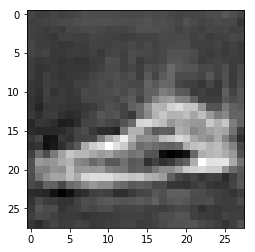

In [43]:
img = G.predict([noise, label])
plt.imshow(img[0,:,:,0]*0.5 + 0.5, cmap="gray")

In [57]:
wrong_label = np.array(6).reshape(-1,1)

In [58]:
validity = D.predict([img, label])
validity

array([[0.3830037]], dtype=float32)

In [59]:
validity = D.predict([img, wrong_label])
validity

array([[0.3802961]], dtype=float32)

In [12]:
idx = np.random.randint(0, X_train.shape[0], 10)
imgs, labels = X_train[idx], y_train[idx]

In [13]:
labels

array([[5],
       [5],
       [7],
       [0],
       [3],
       [6],
       [1],
       [9],
       [0],
       [6]], dtype=uint8)

In [16]:
wrong_labels = np.random.randint(0, 10, 10).reshape(-1, 1)
wrong_labels

array([[5],
       [3],
       [5],
       [0],
       [4],
       [4],
       [4],
       [9],
       [1],
       [3]])

In [18]:
wrong_labels = [(label+1)%10 if label == labels[idx] else label for idx, label in enumerate(wrong_labels)]

In [19]:
wrong_labels

[array([6]),
 array([3]),
 array([5]),
 array([1]),
 array([4]),
 array([4]),
 array([4]),
 array([0]),
 array([1]),
 array([3])]

In [ ]:
# Large amount of credit goes to:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py and
# https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
# which I've used as a reference for this implementation
# Author: Hanling Wang
# Date: 2018-11-21

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import math

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        global batch_size
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
        
class CWGANGP():
    def __init__(self, epochs=100, batch_size=32, sample_interval=50):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.nclasses = 10
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.losslog = []
        self.epochs = epochs
        self.batch_size = batch_size
        self.sample_interval = sample_interval
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        
        # Generate image based of noise (fake sample) and add label to the input 
        label = Input(shape=(1,))
        fake_img = self.generator([z_disc, label])

        # Discriminator determines validity of the real and fake images
        fake = self.critic([fake_img, label])
        valid = self.critic([real_img, label])

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        
        # Determine validity of weighted sample
        validity_interpolated = self.critic([interpolated_img, label])

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, label, z_disc], outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # add label to the input
        label = Input(shape=(1,))
        # Generate images based of noise
        img = self.generator([z_gen, label])
        # Discriminator determines validity
        valid = self.critic([img, label])
        # Defines generator model
        self.generator_model = Model([z_gen, label], valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)
        
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        dropout = 0.4
        depth = 256
        dim = 7
        
        noise = Input(shape=(self.latent_dim,))    
        label = Input(shape=(1,))   
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        model_input = concatenate([noise, label_embedding])
        
        # In: 100
        # Out: dim x dim x depth
        d = Dense(dim*dim*depth, activation="relu")(model_input)
        d = BatchNormalization(momentum=0.9)(d)
        d = Reshape((dim, dim, depth))(d) # 7 x 7 x 256

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        
        c1 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(d) # 16 x 16 x 128
        c1 = BatchNormalization(momentum=0.9)(c1)
        
        c2 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c1) # 16 x 16 x 128
        c2 = BatchNormalization(momentum=0.9)(c2)
        
        c3 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c2) # 16 x 16 x 128
        c3 = BatchNormalization(momentum=0.9)(c3)
        
        c4 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c3) # 16 x 16 x 128
        c4 = BatchNormalization(momentum=0.9)(c4)
        
        a1 = Add()([c1, c4])
        u2 = UpSampling2D()(a1) # 14 x 14 x 128
        
        c5 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(u2) # 32 x 32 x 64
        c5 = BatchNormalization(momentum=0.9)(c5)
        
        c6 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c5) # 32 x 32 x 64
        c6 = BatchNormalization(momentum=0.9)(c6)
        
        c7 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c6) # 32 x 32 x 64
        c7 = BatchNormalization(momentum=0.9)(c7)
        
        c8 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c7) # 32 x 32 x 64
        c8 = BatchNormalization(momentum=0.9)(c8)
        
        a2 = Add()([c5, c8])
        u3 = UpSampling2D()(a2) # 28 x 28 x 64
        
        c9 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(u3) # 64 x 64 x 32
        c9 = BatchNormalization(momentum=0.9)(c9)
        
        c10 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c9) # 64 x 64 x 32
        c10 = BatchNormalization(momentum=0.9)(c10)
        
        c11 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c10) # 64 x 64 x 32
        c11 = BatchNormalization(momentum=0.9)(c11)
        
        c12 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c11) # 64 x 64 x 32
        c12 = BatchNormalization(momentum=0.9)(c12)
        
        a3 = Add()([c9, c12])

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        generated_img = Conv2DTranspose(1, 5, padding='same')(a3) # 64 x 64 x 3
        
        model = Model(inputs = [noise, label], output = generated_img) 
        model.summary()
        return model

    def build_critic(self):

        depth = 64
        dropout = 0.2
        
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,))
        
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        d1 = Dense(256, activation="relu")(label_embedding)
        d2 = Dense(784, activation="relu")(d1)
        label_img_shape = Reshape((28,28,1))(d2)
        
        new_img = concatenate([img, label_img_shape], axis=2)
        
        c1 = Conv2D(depth, 5, padding='same')(new_img)
        c1 = LeakyReLU(alpha=0.2)(c1)
        c1 = Dropout(dropout)(c1) # 32 x 32 x 64
        
        c2 = Conv2D(depth, 5, padding='same')(c1)
        c2 = LeakyReLU(alpha=0.2)(c2)
        c2 = Dropout(dropout)(c2) # 32 x 32 x 64
        
        c3 = Conv2D(depth, 5, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c3)
        c3 = Dropout(dropout)(c3) # 32 x 32 x 64
        
        c4 = Conv2D(depth, 5, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c4)
        c4 = Dropout(dropout)(c4) # 32 x 32 x 64
        
        a1 = Add()([c1, c4])
           
        c5 = Conv2D(depth*2, 5, strides=2, padding='same')(a1)
        c5 = LeakyReLU(alpha=0.2)(c5)
        c5 = Dropout(dropout)(c5) # 16 x 16 x 128
        
        c6 = Conv2D(depth*2, 5, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        c6 = Dropout(dropout)(c6) # 16 x 16 x 128
        
        c7 = Conv2D(depth*2, 5, padding='same')(c6)
        c7 = LeakyReLU(alpha=0.2)(c7)
        c7 = Dropout(dropout)(c7) # 16 x 16 x 128
        
        c8 = Conv2D(depth*2, 5, padding='same')(c7)
        c8 = LeakyReLU(alpha=0.2)(c8)
        c8 = Dropout(dropout)(c8) # 16 x 16 x 128
        
        a2 = Add()([c5, c8])
        
        c9 = Conv2D(depth*4, 5, strides=2, padding='same')(a2)
        c9 = LeakyReLU(alpha=0.2)(c9)
        c9 = Dropout(dropout)(c9) # 8 x 8 x 256
        
        c10 = Conv2D(depth*4, 5, padding='same')(c9)
        c10 = LeakyReLU(alpha=0.2)(c10)
        c10 = Dropout(dropout)(c10) # 8 x 8 x 256
        
        c11 = Conv2D(depth*4, 5, padding='same')(c10)
        c11 = LeakyReLU(alpha=0.2)(c11)
        c11 = Dropout(dropout)(c11) # 8 x 8 x 256
        
        c12 = Conv2D(depth*4, 5, padding='same')(c11)
        c12 = LeakyReLU(alpha=0.2)(c12)
        c12 = Dropout(dropout)(c12) # 8 x 8 x 256
        
        a3 = Add()([c9, c12])
        
        c13 = Conv2D(depth*8, 5, strides=2, padding='same')(a3)
        c13 = LeakyReLU(alpha=0.2)(c13) # 4 x 4 x 512

        f = Flatten()(c13)
        
        d3 = Dense(128, activation="relu")(f)
        validity = Dense(1)(d3)
        
        model = Model(inputs=[img,label], output=validity)
        model.summary()
        return model

    def train(self):
        
        fashion_mnist = keras.datasets.fashion_mnist
        (X_train, y_train), (_, _) = fashion_mnist.load_data()
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=1).reshape(60000,28,28,1)
        
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = -np.ones((self.batch_size, 1))
        fake =  np.ones((self.batch_size, 1))
        invalid =  np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(self.epochs):
            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                 # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], self.batch_size)
                imgs, labels = X_train[idx], y_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, labels, noise], [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------
            sampled_labels = np.random.randint(0, self.nclasses, self.batch_size).reshape(-1, 1)
            g_loss = self.generator_model.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
            self.losslog.append([d_loss[0], g_loss])
            
            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0:
                self.sample_images(epoch)
                self.generator.save_weights('generator', overwrite=True)
                self.critic.save_weights('discriminator', overwrite=True)
                with open('loss.log', 'w') as f:
                    f.writelines('d_loss, g_loss\n')
                    for each in self.losslog:
                        f.writelines('%s, %s\n'%(each[0], each[1]))

    def sample_images(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.array(list(range(10))*10).reshape(-1, 1)
        
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = self.combine_images(gen_imgs)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        plt.figure(figsize=(10,10))
        plt.imshow(gen_imgs, cmap='gray')
        plt.axis('off')
        plt.savefig("images/mnist_%d.png" % epoch)
        plt.close()
    
    def combine_images(self, generated_images):
        num = generated_images.shape[0]
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
        shape = generated_images.shape[1:3]
        image = np.zeros((height*shape[0], width*shape[1]),
                         dtype=generated_images.dtype)
        for index, img in enumerate(generated_images):
            i = int(index/width)
            j = index % width
            image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
                img[:, :, 0]
        return image
    
    def generate_images(self, label):
        self.generator.load_weights('../cwgan_gp/generator')
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict([noise, np.array(label).reshape(-1,1)])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1
        
        plt.imshow(gen_imgs[0,:,:,0], cmap='gray')
        plt.axis('off')

        plt.close()

if __name__ == '__main__':
    epochs = 5000
    batch_size = 32
    sample_interval = 50
    wgan = CWGANGP(epochs, batch_size, sample_interval)
    wgan.train()
    # wgan.generate_images(1) # generate images of a specific class

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:207: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
concatenat

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:288: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1000        input_4[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          25856       flatten_2[0][0]                  
__________________________________________________________________________________________________
dense_3 (D

/opt/anaconda/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
# Large amount of credit goes to:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py and
# https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
# which I've used as a reference for this implementation
# Author: Hanling Wang
# Date: 2018-11-21

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import math

import numpy as np
        
class CWGANGP():
    def __init__(self, epochs=100, batch_size=32, sample_interval=50):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.nclasses = 10
        self.latent_dim = 100
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.losslog = []
        self.epochs = epochs
        self.batch_size = batch_size
        self.sample_interval = sample_interval
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 10
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)
        
        # Generate image based of noise (fake sample) and add label to the input 
        label = Input(shape=(1,))
        wrong_label = Input(shape=(1,))

        # Discriminator determines validity of the real and fake images
        valid = self.critic([real_img, label])
        fake = self.critic([real_img, wrong_label])

        self.critic_model = Model(inputs=[real_img, label, wrong_label], outputs=[valid, fake])
        self.critic_model.summary()
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss],
                                        optimizer=optimizer)

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_critic(self):

        depth = 64
        dropout = 0.2
        
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,))
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        
        c1 = Conv2D(depth, 5, padding='same')(img)
        c1 = LeakyReLU(alpha=0.2)(c1)
        c1 = Dropout(dropout)(c1) # 32 x 32 x 64
        
        c2 = Conv2D(depth, 5, padding='same')(c1)
        c2 = LeakyReLU(alpha=0.2)(c2)
        c2 = Dropout(dropout)(c2) # 32 x 32 x 64
        
        c3 = Conv2D(depth, 5, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c3)
        c3 = Dropout(dropout)(c3) # 32 x 32 x 64
        
        c4 = Conv2D(depth, 5, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c4)
        c4 = Dropout(dropout)(c4) # 32 x 32 x 64
        
        a1 = Add()([c1, c4])
           
        c5 = Conv2D(depth*2, 5, strides=2, padding='same')(a1)
        c5 = LeakyReLU(alpha=0.2)(c5)
        c5 = Dropout(dropout)(c5) # 16 x 16 x 128
        
        c6 = Conv2D(depth*2, 5, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        c6 = Dropout(dropout)(c6) # 16 x 16 x 128
        
        c7 = Conv2D(depth*2, 5, padding='same')(c6)
        c7 = LeakyReLU(alpha=0.2)(c7)
        c7 = Dropout(dropout)(c7) # 16 x 16 x 128
        
        c8 = Conv2D(depth*2, 5, padding='same')(c7)
        c8 = LeakyReLU(alpha=0.2)(c8)
        c8 = Dropout(dropout)(c8) # 16 x 16 x 128
        
        a2 = Add()([c5, c8])
        
        c9 = Conv2D(depth*4, 5, strides=2, padding='same')(a2)
        c9 = LeakyReLU(alpha=0.2)(c9)
        c9 = Dropout(dropout)(c9) # 8 x 8 x 256
        
        c10 = Conv2D(depth*4, 5, padding='same')(c9)
        c10 = LeakyReLU(alpha=0.2)(c10)
        c10 = Dropout(dropout)(c10) # 8 x 8 x 256
        
        c11 = Conv2D(depth*4, 5, padding='same')(c10)
        c11 = LeakyReLU(alpha=0.2)(c11)
        c11 = Dropout(dropout)(c11) # 8 x 8 x 256
        
        c12 = Conv2D(depth*4, 5, padding='same')(c11)
        c12 = LeakyReLU(alpha=0.2)(c12)
        c12 = Dropout(dropout)(c12) # 8 x 8 x 256
        
        a3 = Add()([c9, c12])
        
        c13 = Conv2D(depth*8, 5, strides=2, padding='same')(a3)
        c13 = LeakyReLU(alpha=0.2)(c13) # 4 x 4 x 512

        f = Flatten()(c13)
        f = concatenate([f, label_embedding])
        
        d1 = Dense(512, activation="relu")(f)
        d1 = Dropout(dropout)(d1)
        d2 = Dense(128, activation="relu")(d1)
        d2 = Dropout(dropout)(d2)
        d3 = Dense(128, activation="relu")(d2)
        d3 = Dropout(dropout)(d3)
        d4 = Dense(128, activation="relu")(d3)
        d4 = Dropout(dropout)(d4)
        d5 = Dense(32, activation="relu")(d4)
        validity = Dense(1)(d5)
        
        model = Model(inputs=[img,label], output=validity)
        model.summary()
        return model

    def train(self):
        
        fashion_mnist = keras.datasets.fashion_mnist
        (X_train, y_train), (_, _) = fashion_mnist.load_data()
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=1).reshape(60000,28,28,1)
        
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = -np.ones((self.batch_size, 1))
        fake =  np.ones((self.batch_size, 1))
       
        for epoch in range(self.epochs):
            
            print(epoch)
            
            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], self.batch_size)
                imgs, labels = X_train[idx], y_train[idx]
                # generate wrong labels
                wrong_labels = np.random.randint(0, self.nclasses, self.batch_size)
                wrong_labels = np.array([(label+1)%self.nclasses if label == labels[idx] else label for idx, label in enumerate(wrong_labels)]).reshape(-1, 1)
                print(labels)
                print(wrong_labels)
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, labels, wrong_labels], [valid, fake])
                print("wtf")

            # --------------------

            # Plot the progress
            print ("%d [D loss: %f]" % (epoch, d_loss[0]))
            self.losslog.append([d_loss[0]])

if __name__ == '__main__':
    epochs = 1000
    batch_size = 32
    sample_interval = 10
    wgan = CWGANGP(epochs, batch_size, sample_interval)
    wgan.train()
    # wgan.generate_images(1) # generate images of a specific class

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:153: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 28, 28, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 28, 28, 64)   0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_2 (